# **Toronto Crime Predictions**


---

<a id="0"></a>
## **Table of Contents**


1. [Introduction](#1)
2. [Retrieve Data from API](#2)
3. [Preprocess the Data](#3)
4. [Create the Model](#4)
    1. [Creating the Testing and Training Datasets - First Approach](#4.1)
    2. [Testing Different Models - First Approach](#4.2)
    3. [Optimizing the models - First Approach](#4.3)
        1. [Perform Hyper-Parameter Tuning on the Models](#4.3.1)
            1. [Iterations for Random Forest (RF) Regressor](#4.3.1.1)
            2. [Iterations for Histogram-Based Gradient Boosting (HBGB)](#4.3.1.2)
            3. [Iterations for K-Nearest Neighbors (KNN) Regressor](#4.3.1.3)
        2. [Apply Boosting Algorithms](#4.3.2)
    4. [Creating the Testing and Training Datasets - Second Approach](#4.4)
    5. [Testing Different Models - Second Approach](#4.5)
        1. [Predicting Total Counts](#4.5.1)
        2. [Predicting Assault Counts](#4.5.2)
        3. [Predicting Auto Theft Counts](#4.5.3)
        4. [Predicting Break and Enter Counts](#4.5.4)
        5. [Predicting Robbery Counts](#4.5.5)
        6. [Predicting Theft Over Counts](#4.5.6)
    6. [Optimizing the models - Second Approach](#4.6)
        1. [Auto Theft Models](#4.6.1)
            1. [Apply Regression Chain Boosting Algorithm on RF Regressor](#4.6.1.1)
            2. [Perform Hyper-Parameter Tuning on RF Regression Chain](#4.6.1.2)
            3. [Apply ADA Boosting Algorithm on HBGB](#4.6.1.3)
            4. [Perform Hyper-Parameter Tuning on ADA Boosted HBGB Regressor](#4.6.1.4)
        2. [Total Count Models](#4.6.2)
            1. [Apply Regression Chain Boosting Algorithm on RF Regressor](#4.6.2.1)
            2. [Perform Hyper-Parameter Tuning on RF Regression Chain](#4.6.2.2)
            3. [Apply ADA Boosting Algorithm on HBGB](#4.6.2.3)
            4. [Perform Hyper-Parameter Tuning on ADA Boosted HBGB Regressor](#4.6.2.4)
            5. [Perform Hyper-Parameter Tuning on RF Regressor](#4.6.2.5)
            6. [Perform Hyper-Parameter Tuning on HBGB Regressor](#4.6.2.6)
            7. [Create a Voting Ensemble Learning Model with the default RF and HBGB Models](#4.6.2.7)
                1. [Final Model](#4.6.2.7.1)
5. [Results](#5)
    1. [Visualizations based on current data](#5.1)
        1. [2021-2023 Related Crime Data](#5.1.1)
        2. [Crime Statistics for Previous Years with a Month Breakdown](#5.1.2)
        3. [Crime Statistics for 2021](#5.1.3)
        4. [Crime Statistics for 2022](#5.1.4)
        5. [Crime Statistics for 2023](#5.1.5)
        6. [Comparison of Actual Data and the Predicted Data of 2024](#5.1.6)
    2. [Visualizations based on the Predictions](#5.2)
        1. [Anticipated Crime Statistics for next six months of 2024](#5.2.1)
        2. [Anticipated Total count of Crime Acitivities for upcoming three years](#5.2.2)
        3. [Anticipated Crime Statistics for Upcoming Year with a Month Breakdown](#5.2.3)
        4. [Anticipated Crime Statistics for 2025](#5.2.4)
        5. [Anticipated Crime Statistics for 2026](#5.2.5)
        6. [Anticipated Crime Statistics for 2027](#5.2.6)
6. [Summary and Conclusion](#6)



In [4]:
# Dependencies
import requests
import json
import pprint
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, make_scorer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.multioutput import MultiOutputRegressor, RegressorChain
from sklearn.neighbors import KNeighborsRegressor, RadiusNeighborsRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import folium



---



<a id="1"></a>
## **Introduction**

In [5]:
# prompt: Transform a geojson file located at the following link 'https://drive.google.com/file/d/103OhtbbbBKzd7uDFxtPczUEO6SKrmBkj/view?usp=drive_link' into a geodataframe

# Download the GeoJSON file from Google Drive.
file_id = '103OhtbbbBKzd7uDFxtPczUEO6SKrmBkj'
download_url = f'https://drive.google.com/uc?id={file_id}'

response = requests.get(download_url)
geojson_data = response.json()

# Create a GeoDataFrame from the GeoJSON data.
gdf = gpd.GeoDataFrame.from_features(geojson_data['features'])

# Print the GeoDataFrame.
gdf

geometry  _id  AREA_ID  \
0    MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...    1  2502366   
1    MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...    2  2502365   
2    MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...    3  2502364   
3    MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...    4  2502363   
4    MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...    5  2502362   
..                                                 ...  ...      ...   
153  MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...  154  2502213   
154  MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ...  155  2502212   
155  MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ...  156  2502211   
156  MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ...  157  2502210   
157  MULTIPOLYGON (((-79.53396 43.76886, -79.53227 ...  158  2502209   

     AREA_ATTR_ID  PARENT_AREA_ID AREA_SHORT_CODE AREA_LONG_CODE  \
0        26022881               0             174            174   
1        26022880               0             173            173   
2        26022879               0             172            172   
3        26022878               0             171            171   
4        26022877               0             170            170   
..            ...             ...             ...            ...   
153      26022728               0             001            001   
154      26022727               0             024            024   
155      26022726               0             023            023   
156      26022725               0             022            022   
157      26022724               0             021            021   

                     AREA_NAME                        AREA_DESC  \
0    South Eglinton-Davisville  South Eglinton-Davisville (174)   
1                North Toronto              North Toronto (173)   
2           Dovercourt Village         Dovercourt Village (172)   
3     Junction-Wallace Emerson   Junction-Wallace Emerson (171)   
4           Yonge-Bay Corridor         Yonge-Bay Corridor (170)   
..                         ...                              ...   
153     West Humber-Clairville       West Humber-Clairville (1)   
154                Black Creek                 Black Creek (24)   
155       Pelmo Park-Humberlea        Pelmo Park-Humberlea (23)   
156                 Humbermede                  Humbermede (22)   
157              Humber Summit               Humber Summit (21)   

                           CLASSIFICATION CLASSIFICATION_CODE    OBJECTID  
0    Not an NIA or Emerging Neighbourhood                  NA  17824737.0  
1    Not an NIA or Emerging Neighbourhood                  NA  17824753.0  
2    Not an NIA or Emerging Neighbourhood                  NA  17824769.0  
3    Not an NIA or Emerging Neighbourhood                  NA  17824785.0  
4    Not an NIA or Emerging Neighbourhood                  NA  17824801.0  
..                                    ...                 ...         ...  
153  Not an NIA or Emerging Neighbourhood                  NA  17827185.0  
154        Neighbourhood Improvement Area                 NIA  17827201.0  
155  Not an NIA or Emerging Neighbourhood                  NA  17827217.0  
156        Neighbourhood Improvement Area                 NIA  17827233.0  
157        Neighbourhood Improvement Area                 NIA  17827249.0  

[158 rows x 12 columns]

[back to the top](#0)

In [6]:
# Make a copy of gdf with just the geometry and AREA_DESC column
gdf_hoods = gdf[['geometry', 'AREA_DESC']].copy()

# Rename the AREA_DESC column to NEIGHBOURHOOD_158
gdf_hoods = gdf_hoods.rename(columns={'AREA_DESC': 'NEIGHBOURHOOD_158'})

# Reset the index of gdf_hoods
gdf_hoods = gdf_hoods.reset_index(drop=True)

# Display the updated GeoDataFrame
gdf_hoods

geometry  \
0    MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...   
1    MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...   
2    MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...   
3    MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...   
4    MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...   
..                                                 ...   
153  MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...   
154  MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ...   
155  MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ...   
156  MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ...   
157  MULTIPOLYGON (((-79.53396 43.76886, -79.53227 ...   

                   NEIGHBOURHOOD_158  
0    South Eglinton-Davisville (174)  
1                North Toronto (173)  
2           Dovercourt Village (172)  
3     Junction-Wallace Emerson (171)  
4           Yonge-Bay Corridor (170)  
..                               ...  
153       West Humber-Clairville (1)  
154                 Black Creek (24)  
155        Pelmo Park-Humberlea (23)  
156                  Humbermede (22)  
157               Humber Summit (21)  

[158 rows x 2 columns]

[back to the top](#0)

In [7]:
# prompt: Create a new column in gdf_hoods called 'HOOD_158' containing just the numeric portion of the strings in the 'NEIGHBOURHOOD_158' column
# Extract the numeric portion of the 'NEIGHBOURHOOD_158' column
gdf_hoods['HOOD_158'] = gdf_hoods['NEIGHBOURHOOD_158'].str.extract('(\d+)').fillna(0).astype(int)

# Display dataframe with new column
gdf_hoods

geometry  \
0    MULTIPOLYGON (((-79.38635 43.69783, -79.38623 ...   
1    MULTIPOLYGON (((-79.39744 43.70693, -79.39837 ...   
2    MULTIPOLYGON (((-79.43411 43.66015, -79.43537 ...   
3    MULTIPOLYGON (((-79.4387 43.66766, -79.43841 4...   
4    MULTIPOLYGON (((-79.38404 43.64497, -79.38502 ...   
..                                                 ...   
153  MULTIPOLYGON (((-79.59037 43.73401, -79.58942 ...   
154  MULTIPOLYGON (((-79.51915 43.77399, -79.51901 ...   
155  MULTIPOLYGON (((-79.53225 43.73505, -79.52938 ...   
156  MULTIPOLYGON (((-79.52813 43.74425, -79.52721 ...   
157  MULTIPOLYGON (((-79.53396 43.76886, -79.53227 ...   

                   NEIGHBOURHOOD_158  HOOD_158  
0    South Eglinton-Davisville (174)       174  
1                North Toronto (173)       173  
2           Dovercourt Village (172)       172  
3     Junction-Wallace Emerson (171)       171  
4           Yonge-Bay Corridor (170)       170  
..                               ...       ...  
153       West Humber-Clairville (1)         1  
154                 Black Creek (24)        24  
155        Pelmo Park-Humberlea (23)        23  
156                  Humbermede (22)        22  
157               Humber Summit (21)        21  

[158 rows x 3 columns]

[back to the top](#0)

In [8]:
# prompt: Create an interactive map with gdf_hoods such that a particular multipolygon has a label over it displaying its corresponding neighbourhood name

# The GeoJSON data is in WGS 84 (EPSG:4326), set the CRS for gdf_hoods
gdf_hoods.crs = 'EPSG:4326'

# Create a map centered on Toronto
m = folium.Map(location=[43.6532, -79.3832], zoom_start=10)

# Add the neighbourhoods to the map with labels
for _, row in gdf_hoods.iterrows():
  # Get the neighborhood number and geometry
  hood_num = row['HOOD_158']
  polygon = row['geometry']

  # Calculate the centroid of the polygon for label placement
  centroid = polygon.centroid

  # Add a marker with the neighbourhood name at the centroid
  folium.Marker(
      location=[centroid.y, centroid.x],
      popup=hood_num,
      icon=folium.DivIcon(html=f'<div style="font-size: 8pt;"><strong>{hood_num}</strong></div>')
  ).add_to(m)

folium.GeoJson(
    gdf_hoods,
    name='Neighbourhoods',
    style_function=lambda feature: {
        'fillColor': 'blue',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(fields=['NEIGHBOURHOOD_158'], aliases=['Neighbourhood:'])
).add_to(m)

# Display the map
m

[back to the top](#0)

---

<a id="2"></a>
## **Retrieve Data from API**

[back to the top](#0)

In [9]:
# Initialize the base URL and the initial parameters
base_url = 'https://services.arcgis.com/S9th0jAJ7bqgIRjw/ArcGIS/rest/services/Major_Crime_Indicators_Open_Data/FeatureServer/0/query'
params = {
    'where': 'OCC_YEAR<=2024 AND OCC_YEAR>=2021',
    'outFields': '*',
    'resultRecordCount': 2000,
    'resultOffset': 0,
    'f': 'geojson'
}
# Create an empty list to store all the results
crime_json_array = []
# Start the loop to paginate through the results
while True:
    response = requests.get(base_url, params=params).json()
    # Add the current batch of features to the list
    crime_json_array.extend(response['features'])
    # Check if 'exceededTransferLimit' is True, which means there are more records
    if 'properties' in response and response['properties'].get('exceededTransferLimit', False):
        # Increment the offset to get the next batch of records
        params['resultOffset'] += params['resultRecordCount']
    else:
        # Exit the loop if there are no more records to retrieve
        break

[back to the top](#0)

In [10]:
# View the first three entries of the raw JSON data
crime_json_array[:3]

[{'type': 'Feature',
  'id': 246675,
  'geometry': {'type': 'Point',
   'coordinates': [-79.425761926, 43.6817690130001]},
  'properties': {'OBJECTID': 246675,
   'EVENT_UNIQUE_ID': 'GO-20213605',
   'REPORT_DATE': 1609477200000,
   'OCC_DATE': 1609477200000,
   'REPORT_YEAR': 2021,
   'REPORT_MONTH': 'January',
   'REPORT_DAY': 1,
   'REPORT_DOY': 1,
   'REPORT_DOW': 'Friday    ',
   'REPORT_HOUR': 16,
   'OCC_YEAR': 2021,
   'OCC_MONTH': 'January',
   'OCC_DAY': 1,
   'OCC_DOY': 1,
   'OCC_DOW': 'Friday    ',
   'OCC_HOUR': 16,
   'DIVISION': 'D13',
   'LOCATION_TYPE': 'Parking Lots (Apt., Commercial Or Non-Commercial)',
   'PREMISES_TYPE': 'Outside',
   'UCR_CODE': 2135,
   'UCR_EXT': 210,
   'OFFENCE': 'Theft Of Motor Vehicle',
   'MCI_CATEGORY': 'Auto Theft',
   'HOOD_158': '094',
   'NEIGHBOURHOOD_158': 'Wychwood (94)',
   'HOOD_140': '094',
   'NEIGHBOURHOOD_140': 'Wychwood (94)',
   'LONG_WGS84': -79.42576192637651,
   'LAT_WGS84': 43.68176901263976}},
 {'type': 'Feature',
  'i

[back to the top](#0)

In [11]:
# Using a list comprehension to apply the function for each entry in the intial crime JSON array.
crime_json_list = [crime['properties'] for crime in crime_json_array]
# View the first three entries of the crime JSON list
crime_json_list[:3]

[{'OBJECTID': 246675,
  'EVENT_UNIQUE_ID': 'GO-20213605',
  'REPORT_DATE': 1609477200000,
  'OCC_DATE': 1609477200000,
  'REPORT_YEAR': 2021,
  'REPORT_MONTH': 'January',
  'REPORT_DAY': 1,
  'REPORT_DOY': 1,
  'REPORT_DOW': 'Friday    ',
  'REPORT_HOUR': 16,
  'OCC_YEAR': 2021,
  'OCC_MONTH': 'January',
  'OCC_DAY': 1,
  'OCC_DOY': 1,
  'OCC_DOW': 'Friday    ',
  'OCC_HOUR': 16,
  'DIVISION': 'D13',
  'LOCATION_TYPE': 'Parking Lots (Apt., Commercial Or Non-Commercial)',
  'PREMISES_TYPE': 'Outside',
  'UCR_CODE': 2135,
  'UCR_EXT': 210,
  'OFFENCE': 'Theft Of Motor Vehicle',
  'MCI_CATEGORY': 'Auto Theft',
  'HOOD_158': '094',
  'NEIGHBOURHOOD_158': 'Wychwood (94)',
  'HOOD_140': '094',
  'NEIGHBOURHOOD_140': 'Wychwood (94)',
  'LONG_WGS84': -79.42576192637651,
  'LAT_WGS84': 43.68176901263976},
 {'OBJECTID': 246676,
  'EVENT_UNIQUE_ID': 'GO-20213400',
  'REPORT_DATE': 1609477200000,
  'OCC_DATE': 1609477200000,
  'REPORT_YEAR': 2021,
  'REPORT_MONTH': 'January',
  'REPORT_DAY': 1,
  

[back to the top](#0)

In [12]:
# Convert the JSON array into a Dataframe
crime_data_original = pd.DataFrame(crime_json_list)
# Display the top rows of the Dataframe and the number of rows and columns
crime_data_original

OBJECTID EVENT_UNIQUE_ID    REPORT_DATE       OCC_DATE  REPORT_YEAR  \
0         246675     GO-20213605  1609477200000  1609477200000         2021   
1         246676     GO-20213400  1609477200000  1609477200000         2021   
2         246677     GO-20211123  1609477200000  1609477200000         2021   
3         246678      GO-2021445  1609477200000  1609477200000         2021   
4         246679     GO-20213400  1609477200000  1609477200000         2021   
...          ...             ...            ...            ...          ...   
147546    396731  GO-20241427047  1719723600000  1719637200000         2024   
147547    396732  GO-20241427869  1719723600000  1719723600000         2024   
147548    396733  GO-20241423116  1719723600000  1719637200000         2024   
147549    396734  GO-20241426669  1719723600000  1718859600000         2024   
147550    396735  GO-20241425318  1719723600000  1719637200000         2024   

       REPORT_MONTH  REPORT_DAY  REPORT_DOY  REPORT_DOW  REPORT_HOUR  ...  \
0           January           1           1  Friday               16  ...   
1           January           1           1  Friday               16  ...   
2           January           1           1  Friday                7  ...   
3           January           1           1  Friday                1  ...   
4           January           1           1  Friday               16  ...   
...             ...         ...         ...         ...          ...  ...   
147546         June          30         182  Sunday               16  ...   
147547         June          30         182  Sunday               18  ...   
147548         June          30         182  Sunday                2  ...   
147549         June          30         182  Sunday               15  ...   
147550         June          30         182  Sunday               11  ...   

        UCR_CODE UCR_EXT                        OFFENCE  MCI_CATEGORY  \
0           2135     210         Theft Of Motor Vehicle    Auto Theft   
1           2135     210         Theft Of Motor Vehicle    Auto Theft   
2           2135     210         Theft Of Motor Vehicle    Auto Theft   
3           2135     210         Theft Of Motor Vehicle    Auto Theft   
4           2135     210         Theft Of Motor Vehicle    Auto Theft   
...          ...     ...                            ...           ...   
147546      1430     100                        Assault       Assault   
147547      2133     200       Theft Over - Shoplifting    Theft Over   
147548      1450     120  Discharge Firearm With Intent       Assault   
147549      2132     200  Theft From Motor Vehicle Over    Theft Over   
147550      1430     100                        Assault       Assault   

       HOOD_158                     NEIGHBOURHOOD_158 HOOD_140  \
0           094                         Wychwood (94)      094   
1           NSA                                   NSA      NSA   
2           031               Yorkdale-Glen Park (31)      031   
3           151                     Yonge-Doris (151)      051   
4           NSA                                   NSA      NSA   
...         ...                                   ...      ...   
147546      071  Cabbagetown-South St.James Town (71)      071   
147547      027          York University Heights (27)      027   
147548      144             Morningside Heights (144)      131   
147549      160                Mimico-Queensway (160)      017   
147550      018                      New Toronto (18)      018   

                               NEIGHBOURHOOD_140 LONG_WGS84  LAT_WGS84  
0                                  Wychwood (94) -79.425762  43.681769  
1                                            NSA   0.000000   0.000000  
2                        Yorkdale-Glen Park (31) -79.460110  43.721013  
3                           Willowdale East (51) -79.415293  43.778743  
4                                            NSA   0.000000   0.000000  
...                       

[back to the top](#0)



---



<a id="3"></a>
## **Preprocess the Data**

[back to the top](#0)

In [13]:
# Get all the column names in crime_data_original
crime_data_original.columns

Index(['OBJECTID', 'EVENT_UNIQUE_ID', 'REPORT_DATE', 'OCC_DATE', 'REPORT_YEAR',
       'REPORT_MONTH', 'REPORT_DAY', 'REPORT_DOY', 'REPORT_DOW', 'REPORT_HOUR',
       'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_DOY', 'OCC_DOW', 'OCC_HOUR',
       'DIVISION', 'LOCATION_TYPE', 'PREMISES_TYPE', 'UCR_CODE', 'UCR_EXT',
       'OFFENCE', 'MCI_CATEGORY', 'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140',
       'NEIGHBOURHOOD_140', 'LONG_WGS84', 'LAT_WGS84'],
      dtype='object')

[back to the top](#0)

In [14]:
# Change the value of 'NSA' in the HOOD_158 column to 0 and then convert the column values to integers
crime_data_original['HOOD_158'] = crime_data_original['HOOD_158'].replace('NSA', 0)
crime_data_original['HOOD_158'] = crime_data_original['HOOD_158'].astype(int)
crime_data_original

OBJECTID EVENT_UNIQUE_ID    REPORT_DATE       OCC_DATE  REPORT_YEAR  \
0         246675     GO-20213605  1609477200000  1609477200000         2021   
1         246676     GO-20213400  1609477200000  1609477200000         2021   
2         246677     GO-20211123  1609477200000  1609477200000         2021   
3         246678      GO-2021445  1609477200000  1609477200000         2021   
4         246679     GO-20213400  1609477200000  1609477200000         2021   
...          ...             ...            ...            ...          ...   
147546    396731  GO-20241427047  1719723600000  1719637200000         2024   
147547    396732  GO-20241427869  1719723600000  1719723600000         2024   
147548    396733  GO-20241423116  1719723600000  1719637200000         2024   
147549    396734  GO-20241426669  1719723600000  1718859600000         2024   
147550    396735  GO-20241425318  1719723600000  1719637200000         2024   

       REPORT_MONTH  REPORT_DAY  REPORT_DOY  REPORT_DOW  REPORT_HOUR  ...  \
0           January           1           1  Friday               16  ...   
1           January           1           1  Friday               16  ...   
2           January           1           1  Friday                7  ...   
3           January           1           1  Friday                1  ...   
4           January           1           1  Friday               16  ...   
...             ...         ...         ...         ...          ...  ...   
147546         June          30         182  Sunday               16  ...   
147547         June          30         182  Sunday               18  ...   
147548         June          30         182  Sunday                2  ...   
147549         June          30         182  Sunday               15  ...   
147550         June          30         182  Sunday               11  ...   

        UCR_CODE UCR_EXT                        OFFENCE  MCI_CATEGORY  \
0           2135     210         Theft Of Motor Vehicle    Auto Theft   
1           2135     210         Theft Of Motor Vehicle    Auto Theft   
2           2135     210         Theft Of Motor Vehicle    Auto Theft   
3           2135     210         Theft Of Motor Vehicle    Auto Theft   
4           2135     210         Theft Of Motor Vehicle    Auto Theft   
...          ...     ...                            ...           ...   
147546      1430     100                        Assault       Assault   
147547      2133     200       Theft Over - Shoplifting    Theft Over   
147548      1450     120  Discharge Firearm With Intent       Assault   
147549      2132     200  Theft From Motor Vehicle Over    Theft Over   
147550      1430     100                        Assault       Assault   

       HOOD_158                     NEIGHBOURHOOD_158 HOOD_140  \
0            94                         Wychwood (94)      094   
1             0                                   NSA      NSA   
2            31               Yorkdale-Glen Park (31)      031   
3           151                     Yonge-Doris (151)      051   
4             0                                   NSA      NSA   
...         ...                                   ...      ...   
147546       71  Cabbagetown-South St.James Town (71)      071   
147547       27          York University Heights (27)      027   
147548      144             Morningside Heights (144)      131   
147549      160                Mimico-Queensway (160)      017   
147550       18                      New Toronto (18)      018   

                               NEIGHBOURHOOD_140 LONG_WGS84  LAT_WGS84  
0                                  Wychwood (94) -79.425762  43.681769  
1                                            NSA   0.000000   0.000000  
2                        Yorkdale-Glen Park (31) -79.460110  43.721013  
3                           Willowdale East (51) -79.415293  43.778743  
4                                            NSA   0.000000   0.000000  
...                       

[back to the top](#0)

In [15]:
crime_data_original['OCC_MONTH']

0         January
1         January
2         January
3         January
4         January
           ...   
147546       June
147547       June
147548       June
147549       June
147550       June
Name: OCC_MONTH, Length: 147551, dtype: object

[back to the top](#0)

In [16]:
# prompt: Convert the crime_data_original column OCC_MONTH's month names to integer form

month_mapping = {
    'January': 1,
    'February': 2,
    'March': 3,
    'April': 4,
    'May': 5,
    'June': 6,
    'July': 7,
    'August': 8,
    'September': 9,
    'October': 10,
    'November': 11,
    'December': 12
}

crime_data_original['OCC_MONTH'] = crime_data_original['OCC_MONTH'].map(month_mapping)
crime_data_original['OCC_MONTH']


0         1
1         1
2         1
3         1
4         1
         ..
147546    6
147547    6
147548    6
147549    6
147550    6
Name: OCC_MONTH, Length: 147551, dtype: int64

[back to the top](#0)

In [17]:
# Collect only the necessary columns for the analysis
crime_pd = crime_data_original[['EVENT_UNIQUE_ID', 'NEIGHBOURHOOD_158', 'HOOD_158', 'LAT_WGS84', 'LONG_WGS84', 'PREMISES_TYPE', 'OCC_DATE', 'OCC_YEAR', 'OCC_MONTH', 'OCC_DAY', 'OCC_HOUR', 'MCI_CATEGORY']]
crime_pd


EVENT_UNIQUE_ID                     NEIGHBOURHOOD_158  HOOD_158  \
0          GO-20213605                         Wychwood (94)        94   
1          GO-20213400                                   NSA         0   
2          GO-20211123               Yorkdale-Glen Park (31)        31   
3           GO-2021445                     Yonge-Doris (151)       151   
4          GO-20213400                                   NSA         0   
...                ...                                   ...       ...   
147546  GO-20241427047  Cabbagetown-South St.James Town (71)        71   
147547  GO-20241427869          York University Heights (27)        27   
147548  GO-20241423116             Morningside Heights (144)       144   
147549  GO-20241426669                Mimico-Queensway (160)       160   
147550  GO-20241425318                      New Toronto (18)        18   

        LAT_WGS84  LONG_WGS84 PREMISES_TYPE       OCC_DATE  OCC_YEAR  \
0       43.681769  -79.425762       Outside  1609477200000      2021   
1        0.000000    0.000000    Commercial  1609477200000      2021   
2       43.721013  -79.460110         Other  1609477200000      2021   
3       43.778743  -79.415293         Other  1609477200000      2021   
4        0.000000    0.000000    Commercial  1609477200000      2021   
...           ...         ...           ...            ...       ...   
147546  43.663195  -79.373043     Apartment  1719637200000      2024   
147547  43.759469  -79.464942    Commercial  1719723600000      2024   
147548  43.837237  -79.248477       Outside  1719637200000      2024   
147549  43.616490  -79.521053       Outside  1718859600000      2024   
147550  43.598831  -79.513940         House  1719637200000      2024   

        OCC_MONTH  OCC_DAY  OCC_HOUR MCI_CATEGORY  
0               1        1        16   Auto Theft  
1               1        1         4   Auto Theft  
2               1        1         4   Auto Theft  
3               1        1         1   Auto Theft  
4               1        1         4   Auto Theft  
...           ...      ...       ...          ...  
147546          6       29        23      Assault  
147547          6       30        18   Theft Over  
147548          6       29        21      Assault  
147549          6       20        13   Theft Over  
147550          6       29        20      Assault  

[147551 rows x 12 columns]

[back to the top](#0)

In [18]:
# Encode the MCI_CATEGORY column using get_dummies
crime_category_encoded = pd.get_dummies(crime_pd['MCI_CATEGORY']).astype(int)
crime_category_encoded


Assault  Auto Theft  Break and Enter  Robbery  Theft Over
0             0           1                0        0           0
1             0           1                0        0           0
2             0           1                0        0           0
3             0           1                0        0           0
4             0           1                0        0           0
...         ...         ...              ...      ...         ...
147546        1           0                0        0           0
147547        0           0                0        0           1
147548        1           0                0        0           0
147549        0           0                0        0           1
147550        1           0                0        0           0

[147551 rows x 5 columns]

[back to the top](#0)

In [19]:
# Add the encoded columns back into the datframe
crime_pd = pd.concat([crime_pd, crime_category_encoded], axis=1)
crime_pd_encoded = crime_pd.drop(['MCI_CATEGORY'], axis=1) # Drop the original MCI_CATEGORY column
crime_pd_encoded

EVENT_UNIQUE_ID                     NEIGHBOURHOOD_158  HOOD_158  \
0          GO-20213605                         Wychwood (94)        94   
1          GO-20213400                                   NSA         0   
2          GO-20211123               Yorkdale-Glen Park (31)        31   
3           GO-2021445                     Yonge-Doris (151)       151   
4          GO-20213400                                   NSA         0   
...                ...                                   ...       ...   
147546  GO-20241427047  Cabbagetown-South St.James Town (71)        71   
147547  GO-20241427869          York University Heights (27)        27   
147548  GO-20241423116             Morningside Heights (144)       144   
147549  GO-20241426669                Mimico-Queensway (160)       160   
147550  GO-20241425318                      New Toronto (18)        18   

        LAT_WGS84  LONG_WGS84 PREMISES_TYPE       OCC_DATE  OCC_YEAR  \
0       43.681769  -79.425762       Outside  1609477200000      2021   
1        0.000000    0.000000    Commercial  1609477200000      2021   
2       43.721013  -79.460110         Other  1609477200000      2021   
3       43.778743  -79.415293         Other  1609477200000      2021   
4        0.000000    0.000000    Commercial  1609477200000      2021   
...           ...         ...           ...            ...       ...   
147546  43.663195  -79.373043     Apartment  1719637200000      2024   
147547  43.759469  -79.464942    Commercial  1719723600000      2024   
147548  43.837237  -79.248477       Outside  1719637200000      2024   
147549  43.616490  -79.521053       Outside  1718859600000      2024   
147550  43.598831  -79.513940         House  1719637200000      2024   

        OCC_MONTH  OCC_DAY  OCC_HOUR  Assault  Auto Theft  Break and Enter  \
0               1        1        16        0           1                0   
1               1        1         4        0           1                0   
2               1        1         4        0           1                0   
3               1        1         1        0           1                0   
4               1        1         4        0           1                0   
...           ...      ...       ...      ...         ...              ...   
147546          6       29        23        1           0                0   
147547          6       30        18        0           0                0   
147548          6       29        21        1           0                0   
147549          6       20        13        0           0                0   
147550          6       29        20        1           0                0   

        Robbery  Theft Over  
0             0           0  
1             0           0  
2             0           0  
3             0           0  
4             0           0  
...         ...         ...  
147546        0           0  
147547        0           1  
147548        0           0  
147549        0           1  
147550        0           0  

[147551 rows x 16 columns]

[back to the top](#0)

In [20]:
# Group the values by EVENT_UNIQUE_ID and get the first value for all the columns, except for Assault, Auto Theft, Break and Enter, Robbery, Theft Over
crime_first_group = crime_pd_encoded.groupby('EVENT_UNIQUE_ID')[["NEIGHBOURHOOD_158", "HOOD_158", "LAT_WGS84", "LONG_WGS84", "PREMISES_TYPE", "OCC_DATE", "OCC_YEAR", "OCC_MONTH", "OCC_DAY", "OCC_HOUR"]].first()
crime_first_group

NEIGHBOURHOOD_158  HOOD_158  LAT_WGS84  \
EVENT_UNIQUE_ID                                                         
GO-20211000033             West Queen West (162)       162  43.646286   
GO-2021100004          Morningside Heights (144)       144  43.807252   
GO-20211000054                    Moss Park (73)        73  43.657067   
GO-20211000193   Fort York-Liberty Village (163)       163  43.636618   
GO-20211000248               Eglinton East (138)       138  43.737099   
...                                          ...       ...        ...   
GO-20249997       Junction-Wallace Emerson (171)       171  43.668917   
GO-202499972        Edenbridge-Humber Valley (9)         9  43.672705   
GO-2024999786               Flemingdon Park (44)        44  43.718727   
GO-2024999795                     Oakridge (121)       121  43.691225   
GO-2024999882                Eglinton East (138)       138  43.738856   

                 LONG_WGS84 PREMISES_TYPE       OCC_DATE  OCC_YEAR  OCC_MONTH  \
EVENT_UNIQUE_ID                                                                 
GO-20211000033   -79.408568    Commercial  1622264400000      2021          5   
GO-2021100004    -79.162903       Outside  1610773200000      2021          1   
GO-20211000054   -79.374531     Apartment  1622264400000      2021          5   
GO-20211000193   -79.399704     Apartment  1622264400000      2021          5   
GO-20211000248   -79.246230       Outside  1622264400000      2021          5   
...                     ...           ...            ...       ...        ...   
GO-20249997      -79.442637       Outside  1704085200000      2024          1   
GO-202499972     -79.522472         House  1705208400000      2024          1   
GO-2024999786    -79.334948     Apartment  1714539600000      2024          5   
GO-2024999795    -79.288346    Commercial  1715230800000      2024          5   
GO-2024999882    -79.238421    Commercial  1715230800000      2024          5   

                 OCC_DAY  OCC_HOUR  
EVENT_UNIQUE_ID                     
GO-20211000033        29        21  
GO-2021100004         16        17  
GO-20211000054        29        22  
GO-20211000193        29        23  
GO-20211000248        29        21  
...                  ...       ...  
GO-20249997            1        18  
GO-202499972          14         3  
GO-2024999786          1         0  
GO-2024999795          9        13  
GO-2024999882          9        14  

[129217 rows x 10 columns]

[back to the top](#0)

In [21]:
# Group the MCI_CATEGORY values by EVENT_UNIQUE_ID and get the maximum value.
crime_max_group = crime_pd_encoded.groupby('EVENT_UNIQUE_ID')[["Assault", "Auto Theft", "Break and Enter", "Robbery", "Theft Over"]].max()
crime_max_group

Assault  Auto Theft  Break and Enter  Robbery  Theft Over
EVENT_UNIQUE_ID                                                           
GO-20211000033         0           0                1        0           0
GO-2021100004          0           1                0        0           0
GO-20211000054         1           0                0        0           0
GO-20211000193         1           0                0        0           0
GO-20211000248         1           0                0        0           0
...                  ...         ...              ...      ...         ...
GO-20249997            0           1                0        0           0
GO-202499972           0           1                0        0           0
GO-2024999786          1           0                0        0           0
GO-2024999795          1           0                0        0           0
GO-2024999882          1           0                0        0           0

[129217 rows x 5 columns]

[back to the top](#0)

In [22]:
# Concatenate the two groups together into one Dataframe and reset the index so that EVENT_UNIQUE_ID is not the index.
crime_groups_joined = pd.concat([crime_first_group, crime_max_group], axis=1)
crime_groups_joined = crime_groups_joined.reset_index()
crime_groups_joined

EVENT_UNIQUE_ID                NEIGHBOURHOOD_158  HOOD_158  LAT_WGS84  \
0       GO-20211000033            West Queen West (162)       162  43.646286   
1        GO-2021100004        Morningside Heights (144)       144  43.807252   
2       GO-20211000054                   Moss Park (73)        73  43.657067   
3       GO-20211000193  Fort York-Liberty Village (163)       163  43.636618   
4       GO-20211000248              Eglinton East (138)       138  43.737099   
...                ...                              ...       ...        ...   
129212     GO-20249997   Junction-Wallace Emerson (171)       171  43.668917   
129213    GO-202499972     Edenbridge-Humber Valley (9)         9  43.672705   
129214   GO-2024999786             Flemingdon Park (44)        44  43.718727   
129215   GO-2024999795                   Oakridge (121)       121  43.691225   
129216   GO-2024999882              Eglinton East (138)       138  43.738856   

        LONG_WGS84 PREMISES_TYPE       OCC_DATE  OCC_YEAR  OCC_MONTH  OCC_DAY  \
0       -79.408568    Commercial  1622264400000      2021          5       29   
1       -79.162903       Outside  1610773200000      2021          1       16   
2       -79.374531     Apartment  1622264400000      2021          5       29   
3       -79.399704     Apartment  1622264400000      2021          5       29   
4       -79.246230       Outside  1622264400000      2021          5       29   
...            ...           ...            ...       ...        ...      ...   
129212  -79.442637       Outside  1704085200000      2024          1        1   
129213  -79.522472         House  1705208400000      2024          1       14   
129214  -79.334948     Apartment  1714539600000      2024          5        1   
129215  -79.288346    Commercial  1715230800000      2024          5        9   
129216  -79.238421    Commercial  1715230800000      2024          5        9   

        OCC_HOUR  Assault  Auto Theft  Break and Enter  Robbery  Theft Over  
0             21        0           0                1        0           0  
1             17        0           1                0        0           0  
2             22        1           0                0        0           0  
3             23        1           0                0        0           0  
4             21        1           0                0        0           0  
...          ...      ...         ...              ...      ...         ...  
129212        18        0           1                0        0           0  
129213         3        0           1                0        0           0  
129214         0        1           0                0        0           0  
129215        13        1           0                0        0           0  
129216        14        1           0                0        0           0  

[129217 rows x 16 columns]

---

<a id="4"></a>
## **Create the Model**

<a id="4.1"></a>
### Creating the Testing and Training Datasets - First Approach

[back to the top](#0)

In [26]:
# Create a Total_Count column in the crime_groups_joined dataframe
crime_groups_joined['Total_Count'] = crime_groups_joined.iloc[:, 11:].sum(axis=1)
crime_groups_joined

EVENT_UNIQUE_ID                NEIGHBOURHOOD_158  HOOD_158  LAT_WGS84  \
0       GO-20211000033            West Queen West (162)       162  43.646286   
1        GO-2021100004        Morningside Heights (144)       144  43.807252   
2       GO-20211000054                   Moss Park (73)        73  43.657067   
3       GO-20211000193  Fort York-Liberty Village (163)       163  43.636618   
4       GO-20211000248              Eglinton East (138)       138  43.737099   
...                ...                              ...       ...        ...   
129212     GO-20249997   Junction-Wallace Emerson (171)       171  43.668917   
129213    GO-202499972     Edenbridge-Humber Valley (9)         9  43.672705   
129214   GO-2024999786             Flemingdon Park (44)        44  43.718727   
129215   GO-2024999795                   Oakridge (121)       121  43.691225   
129216   GO-2024999882              Eglinton East (138)       138  43.738856   

        LONG_WGS84 PREMISES_TYPE       OCC_DATE  OCC_YEAR  OCC_MONTH  OCC_DAY  \
0       -79.408568    Commercial  1622264400000      2021          5       29   
1       -79.162903       Outside  1610773200000      2021          1       16   
2       -79.374531     Apartment  1622264400000      2021          5       29   
3       -79.399704     Apartment  1622264400000      2021          5       29   
4       -79.246230       Outside  1622264400000      2021          5       29   
...            ...           ...            ...       ...        ...      ...   
129212  -79.442637       Outside  1704085200000      2024          1        1   
129213  -79.522472         House  1705208400000      2024          1       14   
129214  -79.334948     Apartment  1714539600000      2024          5        1   
129215  -79.288346    Commercial  1715230800000      2024          5        9   
129216  -79.238421    Commercial  1715230800000      2024          5        9   

        OCC_HOUR  Assault  Auto Theft  Break and Enter  Robbery  Theft Over  \
0             21        0           0                1        0           0   
1             17        0           1                0        0           0   
2             22        1           0                0        0           0   
3             23        1           0                0        0           0   
4             21        1           0                0        0           0   
...          ...      ...         ...              ...      ...         ...   
129212        18        0           1                0        0           0   
129213         3        0           1                0        0           0   
129214         0        1           0                0        0           0   
129215        13        1           0                0        0           0   
129216        14        1           0                0        0           0   

        Total_Count  
0                 1  
1                 1  
2                 1  
3                 1  
4                 1  
...             ...  
129212            1  
129213            1  
129214            1  
129215            1  
129216            1  

[129217 rows x 17 columns]

[back to the top](#0)

In [27]:
# Group the crime_groups_joined dataframe by neighbourhood, occ_year, occ_month,
# get the count of the rows aggregated to each group, and place those values in the Total_Count column.
crime_totals_by_month_year_hood = crime_groups_joined.groupby(['HOOD_158', 'OCC_YEAR', 'OCC_MONTH'])[['Total_Count']].count()
crime_totals_by_month_year_hood = crime_totals_by_month_year_hood.reset_index()
crime_totals_by_month_year_hood

HOOD_158  OCC_YEAR  OCC_MONTH  Total_Count
0            0      2021          1           44
1            0      2021          2           34
2            0      2021          3           45
3            0      2021          4           26
4            0      2021          5           37
...        ...       ...        ...          ...
6672       174      2024          2           15
6673       174      2024          3            7
6674       174      2024          4           17
6675       174      2024          5           12
6676       174      2024          6           13

[6677 rows x 4 columns]

[back to the top](#0)

In [28]:
# Group the crime_groups_joined dataframe by neighbourhood, occ_year, occ_month and get the sum of assaults, auto theft, break and enter, robbery, and theft over.
crime_types_by_month_year_hood = crime_groups_joined.groupby(['HOOD_158', 'OCC_YEAR', 'OCC_MONTH'])[["Assault", "Auto Theft", "Break and Enter", "Robbery", "Theft Over"]].sum()
crime_types_by_month_year_hood = crime_types_by_month_year_hood.reset_index()
# Concatenate crime_totals_by_month_year_hood and crime_types_by_month_year_hood intot a single dataframe
crime_by_month_year_hood = pd.concat([crime_types_by_month_year_hood, crime_totals_by_month_year_hood['Total_Count']], axis=1)
crime_by_month_year_hood.sort_values(by=['Total_Count'])

HOOD_158  OCC_YEAR  OCC_MONTH  Assault  Auto Theft  Break and Enter  \
1895        49      2021          6        1           0                1   
2229        58      2021          4        0           0                1   
1909        49      2022          8        0           1                0   
5208       140      2021          2        1           0                0   
1890        49      2021          1        0           0                1   
...        ...       ...        ...      ...         ...              ...   
77           1      2023         12       30          45               28   
68           1      2023          3       18          83               12   
65           1      2022         12       24          67               15   
71           1      2023          6       24          77               22   
66           1      2023          1       18          91               14   

      Robbery  Theft Over  Total_Count  
1895        0           0            1  
2229        0           0            1  
1909        0           0            1  
5208        0           0            1  
1890        0           0            1  
...       ...         ...          ...  
77          4          13          118  
68          3           3          119  
65          4          10          120  
71          4           5          131  
66          3           7          133  

[6677 rows x 9 columns]

[back to the top](#0)

In [29]:
# Show all the rows where HOOD_158 has a value of 0
crime_by_month_year_hood.loc[crime_by_month_year_hood['HOOD_158'] == 0, :]

HOOD_158  OCC_YEAR  OCC_MONTH  Assault  Auto Theft  Break and Enter  \
0          0      2021          1       23           2               10   
1          0      2021          2       24           1                8   
2          0      2021          3       27           7                5   
3          0      2021          4       16           1                3   
4          0      2021          5       30           3                3   
5          0      2021          6       22           3                3   
6          0      2021          7       29           2                3   
7          0      2021          8       48           6                2   
8          0      2021          9       27           8                6   
9          0      2021         10       39           9               15   
10         0      2021         11       26          10                6   
11         0      2021         12       22           5                8   
12         0      2022          1       32           7                6   
13         0      2022          2       30          10                3   
14         0      2022          3       34           1                6   
15         0      2022          4       28           8                3   
16         0      2022          5       27          13                6   
17         0      2022          6       25           7                4   
18         0      2022          7       27          10                6   
19         0      2022          8       28           6                6   
20         0      2022          9       36          19                7   
21         0      2022         10       35          10                5   
22         0      2022         11       37          12                5   
23         0      2022         12       25          12                2   
24         0      2023          1       24           9                2   
25         0      2023          2       17          12                1   
26         0      2023          3       20          14                1   
27         0      2023          4       17          12                1   
28         0      2023          5       22           6                0   
29         0      2023          6       13          13                0   
30         0      2023          7       27          12                1   
31         0      2023          8       15          11                1   
32         0      2023          9       15          16                1   
33         0      2023         10       20          14                0   
34         0      2023         11       25          10                3   
35         0      2023         12       24           5                0   
36         0      2024          1       21           4                2   
37         0      2024          2       17           4                0   
38         0      2024          3       19           7                4   
39         0      2024          4       19           5                1   
40         0      2024          5       17          12                4   
41         0      2024          6       20           7                0   

    Robbery  Theft Over  Total_Count  
0         9           1           44  
1         1           0           34  
2         5           3           45  
3         3           3           26  
4         1           1           37  
5         2           3           32  
6         6           2           42  
7         7           3           66  
8         3           3           47  
9         2           2           65  
10        4           4           50  
11        2           1           37  
12        3           2           50  
13        1           1           45  
14        7           3           50  
15       11           3           52  
16        2          10           56  
17        4           2           41  
18        6           2           51 

[back to the top](#0)

In [30]:
# Filter out the rows where the column HOOD_158 has a value of 0
crime_by_month_year_hood = crime_by_month_year_hood.loc[crime_by_month_year_hood['HOOD_158'] != 0, :]
crime_by_month_year_hood = crime_by_month_year_hood.reset_index(drop=True)
crime_by_month_year_hood

HOOD_158  OCC_YEAR  OCC_MONTH  Assault  Auto Theft  Break and Enter  \
0            1      2021          1       18          35                7   
1            1      2021          2       17          17                5   
2            1      2021          3       15          20                8   
3            1      2021          4       11          31                4   
4            1      2021          5       18          26                9   
...        ...       ...        ...      ...         ...              ...   
6630       174      2024          2        9           0                5   
6631       174      2024          3        6           1                0   
6632       174      2024          4       12           2                2   
6633       174      2024          5        8           1                2   
6634       174      2024          6        6           4                1   

      Robbery  Theft Over  Total_Count  
0           1           3           62  
1           1           3           43  
2           6           6           54  
3           2           4           52  
4           5           4           62  
...       ...         ...          ...  
6630        1           1           15  
6631        0           0            7  
6632        0           1           17  
6633        0           1           12  
6634        1           1           13  

[6635 rows x 9 columns]

In [31]:
# Have the training data be all the data in crime_by_month_year_hood for the years 2021 to 2023
train_data = crime_by_month_year_hood.loc[crime_by_month_year_hood['OCC_YEAR'].isin([2021, 2022, 2023]), :]

# Have the testing data be all the data in crime_by_month_year_hood for the year 2024
test_data = crime_by_month_year_hood.loc[crime_by_month_year_hood['OCC_YEAR'] == 2024, :]

In [32]:
# Split the training data into the features and targets
X_train = train_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

X_test = test_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

y_train = train_data[['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over', 'Total_Count']]  # Target

y_test = test_data[['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over', 'Total_Count']]  # Target

<a id="4.2"></a>
### Testing Different Models - First Approach

[back to the top](#0)

In [33]:
# Initialize the Random Forest Regressor
r_model = RandomForestRegressor()

# Train the model on the training data
r_model.fit(X_train, y_train)

RandomForestRegressor()

In [34]:
# Initialize the Histogram-Based Gradient Boosting Regressor and wrap it with MultiOutputRegressor
h_model = MultiOutputRegressor(HistGradientBoostingRegressor())

# Train the model on the training data
h_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=HistGradientBoostingRegressor())

In [35]:
# Initialize the Lasso Regressor
l_model = Lasso()

# Train the model on the training data
l_model.fit(X_train, y_train)

Lasso()

In [36]:
# Initialize the Extra-Trees Regressor
e_model = ExtraTreesRegressor()

# Train the model on the training data
e_model.fit(X_train, y_train)

ExtraTreesRegressor()

[back to the top](#0)

In [37]:
# Initialize the K-Nearest Neighbors Regressor
k_model = KNeighborsRegressor()

# Train the model on the training data
k_model.fit(X_train, y_train)

KNeighborsRegressor()

In [38]:
# Initialize the Elastic Net Regressor
e_n_model = ElasticNet()

# Train the model on the training data
e_n_model.fit(X_train, y_train)

ElasticNet()

In [39]:
# Initialize the Radius Neighbors Regressor
r_n_model = RadiusNeighborsRegressor()

# Train the model on the training data
r_n_model.fit(X_train, y_train)

RadiusNeighborsRegressor()

[back to the top](#0)

In [40]:
# Make predictions on the test set with the Random Forest Regressor
y_r_pred = r_model.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor
y_h_pred = h_model.predict(X_test)

# Make predictions on the test set with the Lasso Regressor
y_l_pred = l_model.predict(X_test)

# Make predictions on the test set with the Extra-Trees Regressor
y_e_pred = e_model.predict(X_test)

# Make predictions on the test set with the K-Nearest Neighbors Regressor
y_k_pred = k_model.predict(X_test)

# Make predictions on the test set with the Elastic Net Regressor
y_e_n_pred = e_n_model.predict(X_test)

# Make predictions on the test set with the Radius Neighbors Regressor
y_r_n_pred = r_n_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


In [41]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Random Forests Results")
print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Random Forests Results
Mean Squared Error: 16.345516578762318
R-squared: 0.42185755406596
mean absolute error: 2.507420886075949


In [42]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting.
h_mse = mean_squared_error(y_test, y_h_pred)
h_r2 = r2_score(y_test, y_h_pred)
h_mae = mean_absolute_error(y_test, y_h_pred)

print(f"Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_mse}")
print(f"R-squared: {h_r2}")
print(f"mean absolute error: {h_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 13.53697402119441
R-squared: 0.5401264890283979
mean absolute error: 2.3624557106149555


In [43]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Lasso Regressor
l_mse = mean_squared_error(y_test, y_l_pred)
l_r2 = r2_score(y_test, y_l_pred)
l_mae = mean_absolute_error(y_test, y_l_pred)

print(f"Lasso Regressor Results")
print(f"Mean Squared Error: {l_mse}")
print(f"R-squared: {l_r2}")
print(f"mean absolute error: {l_mae}")

Lasso Regressor Results
Mean Squared Error: 56.06504159690181
R-squared: 0.0008593089048466821
mean absolute error: 4.053649104634542


In [44]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Extra-Trees Regressor
e_mse = mean_squared_error(y_test, y_e_pred)
e_r2 = r2_score(y_test, y_e_pred)
e_mae = mean_absolute_error(y_test, y_e_pred)

print(f"Extra-Trees Regressor Results")
print(f"Mean Squared Error: {e_mse}")
print(f"R-squared: {e_r2}")
print(f"mean absolute error: {e_mae}")

Extra-Trees Regressor Results
Mean Squared Error: 21.009235548523208
R-squared: 0.2633688550325657
mean absolute error: 2.8370112517580868


[back to the top](#0)

In [45]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for K-Nearest Neighbors Regressor
k_mse = mean_squared_error(y_test, y_k_pred)
k_r2 = r2_score(y_test, y_k_pred)
k_mae = mean_absolute_error(y_test, y_k_pred)

print(f"K-Nearest Neighbors Regressor Results")
print(f"Mean Squared Error: {k_mse}")
print(f"R-squared: {k_r2}")
print(f"mean absolute error: {k_mae}")

K-Nearest Neighbors Regressor Results
Mean Squared Error: 22.812032348804497
R-squared: 0.3917381351580209
mean absolute error: 2.9212025316455694


In [46]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Elastic Net Regressor
e_n_mse = mean_squared_error(y_test, y_e_n_pred)
e_n_r2 = r2_score(y_test, y_e_n_pred)
e_n_mae = mean_absolute_error(y_test, y_e_n_pred)

print(f"Elastic Net Regressor Results")
print(f"Mean Squared Error: {e_n_mse}")
print(f"R-squared: {e_n_r2}")
print(f"mean absolute error: {e_n_mae}")

Elastic Net Regressor Results
Mean Squared Error: 55.83116626511688
R-squared: 0.0018104521500861837
mean absolute error: 4.0478073837331445


In [47]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Radius Neighbors Regressor
r_n_mse = mean_squared_error(y_test, y_r_n_pred)
r_n_r2 = r2_score(y_test, y_r_n_pred)
r_n_mae = mean_absolute_error(y_test, y_r_n_pred)

print(f"Radius Neighbors Regressor Results")
print(f"Mean Squared Error: {r_n_mse}")
print(f"R-squared: {r_n_r2}")
print(f"mean absolute error: {r_n_mae}")

Radius Neighbors Regressor Results
Mean Squared Error: 8.973691110784241e+34
R-squared: -1.48166511902087e+34
mean absolute error: 9729295397526136.0


<a id="4.3"></a>
### Optimizing the models - First Approach

In [259]:
# Create scorers for R-squared and MAE
r2_scorer = make_scorer(r2_score)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)  # Minimize MAE

<a id="4.3.1"></a>
##### **Perform Hyper-Parameter Tuning on the Models**

Hyper-Parameter Tuning was performed on the following models, since they yielded the highest R-squared scores:


*   Random Forest Regressor
*   Histogram-Based Gradient Boosting
*   K-Nearest Neighbors Regressor



<a id="4.3.1.1"></a>
###### Iterations for Random Forest (RF) Regressor

[back to the top](#0)

In [260]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=10,
    scoring=make_scorer(mean_squared_error, greater_is_better=False),
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.928958393105038
R-squared: 0.49663590673300156
mean absolute error: 2.6323390583657864


In [261]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=10,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.928958393105038
R-squared: 0.49663590673300156
mean absolute error: 2.6323390583657864


In [262]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=20,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.900895599495165
R-squared: 0.49718000005206253
mean absolute error: 2.6397685170607654


In [263]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=20,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=15,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': 5}
Mean Squared Error: 37.38108382013141
R-squared: 0.24787742552140726
mean absolute error: 3.5582910596792368


In [264]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.900895599495165
R-squared: 0.49718000005206253
mean absolute error: 2.6397685170607654


In [265]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.900895599495165
R-squared: 0.49718000005206253
mean absolute error: 2.6397685170607654


In [266]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [75, 100, 200],
    'max_depth': [8, 10, 20],
    'min_samples_split': [10, 15, 30],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.900895599495165
R-squared: 0.49718000005206253
mean absolute error: 2.6397685170607654


In [267]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [15, 35, 55],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 300, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 18.358640232112
R-squared: 0.49228192721420205
mean absolute error: 2.66464858496764


In [268]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [100, 150, 250],
    'max_depth': [10, 20, 30],
    'min_samples_split': [15, 35, 55],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 250, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 18.348343979326263
R-squared: 0.49257004515939246
mean absolute error: 2.6625904431614718


In [269]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [150, 250, 350, 450],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [15, 35, 55, 75],
    'min_samples_leaf': [2, 4, 6, 8]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 450, 'min_samples_split': 15, 'min_samples_leaf': 8, 'max_depth': 10}
Mean Squared Error: 18.777789215683814
R-squared: 0.485768406447904
mean absolute error: 2.6973421196246625


In [270]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [15, 35, 55, 75],
    'min_samples_leaf': [1, 2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object (similar to HGB)
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=25,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 400, 'min_samples_split': 55, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 23.92497566088106
R-squared: 0.4239082506998882
mean absolute error: 2.9652493531921866


In [271]:
# Define the hyperparameter search space for Random Forest Regressor
param_dist_reg = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Create the model for Random Forest Regressor
rf_model = RandomForestRegressor(random_state=1)

# Create RandomizedSearchCV object
random_search_reg = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist_reg,
    n_iter=20,
    scoring=r2_scorer,  # Use R-squared as the primary scoring metric
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_reg.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_reg.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_rf_model = random_search_reg.best_estimator_

# Make predictions on the test set with the Random Forest Regressor
y_r_pred = best_rf_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests.
r_mse = mean_squared_error(y_test, y_r_pred)
r_r2 = r2_score(y_test, y_r_pred)
r_mae = mean_absolute_error(y_test, y_r_pred)

print(f"Mean Squared Error: {r_mse}")
print(f"R-squared: {r_r2}")
print(f"mean absolute error: {r_mae}")

Best Hyperparameters: {'n_estimators': 100, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Mean Squared Error: 17.900895599495165
R-squared: 0.49718000005206253
mean absolute error: 2.6397685170607654


[back to the top](#0)

<a id="4.3.1.2"></a>
###### Iterations for Histogram-Based Gradient Boosting (HBGB)

In [272]:
# Define the hyperparameter search space for Histogram-Based Gradient Boosting Regressor wrapped with MultiOutputRegressor
param_dist_hist = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [3, 5, 7],
    'estimator__l2_regularization': [0.0, 0.1, 0.2]
}

# Create the Histogram-Based Gradient Boosting Regressor and wrap it with MultiOutputRegressor
hgb_model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=1))

# Create RandomizedSearchCV object with multiple scoring metrics
random_search_hist = RandomizedSearchCV(
    estimator=hgb_model,
    param_distributions=param_dist_hist,
    n_iter=10,
    scoring={'r2': r2_scorer, 'mae': mae_scorer},  # Multiple scorers
    refit='r2',  # Refit on R-squared
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_hist.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_hist.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_hgb_model = random_search_hist.best_estimator_

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor
y_h_pred = best_hgb_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting.
h_mse = mean_squared_error(y_test, y_h_pred)
h_r2 = r2_score(y_test, y_h_pred)
h_mae = mean_absolute_error(y_test, y_h_pred)

print(f"Mean Squared Error: {h_mse}")
print(f"R-squared: {h_r2}")
print(f"mean absolute error: {h_mae}")

Best Hyperparameters: {'estimator__max_depth': 7, 'estimator__learning_rate': 0.01, 'estimator__l2_regularization': 0.2}
Mean Squared Error: 32.18282924168508
R-squared: 0.3320401942652549
mean absolute error: 3.2649741520630413


In [273]:
# Define the hyperparameter search space for Histogram-Based Gradient Boosting Regressor wrapped with MultiOutputRegressor
param_dist_hist = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [None, 3, 5],
    'estimator__min_samples_leaf': [10, 20, 40],
    'estimator__l2_regularization': [0.0, 0.1, 0.2]
}

# Create the Histogram-Based Gradient Boosting Regressor and wrap it with MultiOutputRegressor
hgb_model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=1))

# Create RandomizedSearchCV object with multiple scoring metrics
random_search_hist = RandomizedSearchCV(
    estimator=hgb_model,
    param_distributions=param_dist_hist,
    n_iter=20,
    scoring=r2_scorer,  # Use R-squared as the primary scoring metric
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_hist.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_hist.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_hgb_model = random_search_hist.best_estimator_

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor
y_h_pred = best_hgb_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting.
h_mse = mean_squared_error(y_test, y_h_pred)
h_r2 = r2_score(y_test, y_h_pred)
h_mae = mean_absolute_error(y_test, y_h_pred)

print(f"Mean Squared Error: {h_mse}")
print(f"R-squared: {h_r2}")
print(f"mean absolute error: {h_mae}")

Best Hyperparameters: {'estimator__min_samples_leaf': 40, 'estimator__max_depth': None, 'estimator__learning_rate': 0.01, 'estimator__l2_regularization': 0.0}
Mean Squared Error: 34.768348922898916
R-squared: 0.28056428760433166
mean absolute error: 3.322235227775795


In [274]:
# Define the hyperparameter search space for Histogram-Based Gradient Boosting Regressor wrapped with MultiOutputRegressor
param_dist_hist = {
    'estimator__learning_rate': [0.01, 0.1, 0.2],
    'estimator__max_depth': [None, 3, 5],
    'estimator__min_samples_leaf': [10, 20, 40],
    'estimator__l2_regularization': [0.0, 0.1, 0.2]
}

# Create the Histogram-Based Gradient Boosting Regressor and wrap it with MultiOutputRegressor
hgb_model = MultiOutputRegressor(HistGradientBoostingRegressor(random_state=1))

# Create RandomizedSearchCV object with multiple scoring metrics
random_search_hist = RandomizedSearchCV(
    estimator=hgb_model,
    param_distributions=param_dist_hist,
    n_iter=10,
    scoring=r2_scorer,  # Use R-squared as the primary scoring metric
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_hist.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_hist.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_hgb_model = random_search_hist.best_estimator_

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor
y_h_pred = best_hgb_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting.
h_mse = mean_squared_error(y_test, y_h_pred)
h_r2 = r2_score(y_test, y_h_pred)
h_mae = mean_absolute_error(y_test, y_h_pred)

print(f"Mean Squared Error: {h_mse}")
print(f"R-squared: {h_r2}")
print(f"mean absolute error: {h_mae}")

Best Hyperparameters: {'estimator__min_samples_leaf': 10, 'estimator__max_depth': None, 'estimator__learning_rate': 0.01, 'estimator__l2_regularization': 0.1}
Mean Squared Error: 27.707811341396553
R-squared: 0.39456052080811127
mean absolute error: 3.123993487397762


[back to the top](#0)

<a id="4.3.1.3"></a>
###### Iterations for K-Nearest Neighbors (KNN) Regressor

In [275]:
# Define the hyperparameter search space for K-Nearest Neighbors Regressor
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Creat the model for K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Create RandomizedSearchCV object
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=10,
    scoring=r2_scorer,  # Use R-squared as the primary scoring metric
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_knn.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_knn.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_knn_model = random_search_knn.best_estimator_

# Make predictions on the test set with the K-Nearest Neighbors Regressor
y_k_pred = best_knn_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for K-Nearest Neighbors Regressor.
k_mse = mean_squared_error(y_test, y_k_pred)
k_r2 = r2_score(y_test, y_k_pred)
k_mae = mean_absolute_error(y_test, y_k_pred)

print(f"Mean Squared Error: {k_mse}")
print(f"R-squared: {k_r2}")
print(f"mean absolute error: {k_mae}")

Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 9}
Mean Squared Error: 18.85456904070352
R-squared: 0.46409840345829956
mean absolute error: 2.643735813566883


In [276]:
# Define the hyperparameter search space for K-Nearest Neighbors Regressor
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Creat the model for K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Create RandomizedSearchCV object
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=20,
    scoring=r2_scorer,  # Use R-squared as the primary scoring metric
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_knn.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_knn.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_knn_model = random_search_knn.best_estimator_

# Make predictions on the test set with the K-Nearest Neighbors Regressor
y_k_pred = best_knn_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for K-Nearest Neighbors Regressor.
k_mse = mean_squared_error(y_test, y_k_pred)
k_r2 = r2_score(y_test, y_k_pred)
k_mae = mean_absolute_error(y_test, y_k_pred)

print(f"Mean Squared Error: {k_mse}")
print(f"R-squared: {k_r2}")
print(f"mean absolute error: {k_mae}")

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 9}
Mean Squared Error: 18.85456904070352
R-squared: 0.46409840345829956
mean absolute error: 2.643735813566883


In [277]:
# Define the hyperparameter search space for K-Nearest Neighbors Regressor
param_dist_knn = {
    'n_neighbors': [7, 9, 11, 13],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]  # 1 for Manhattan distance, 2 for Euclidean distance
}

# Creat the model for K-Nearest Neighbors Regressor
knn_model = KNeighborsRegressor()

# Create RandomizedSearchCV object
random_search_knn = RandomizedSearchCV(
    estimator=knn_model,
    param_distributions=param_dist_knn,
    n_iter=16,
    scoring=r2_scorer,  # Use R-squared as the primary scoring metric
    cv=5,
    random_state=1,
    n_jobs=-1
)

# Perform the hyperparameter search
random_search_knn.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search_knn.best_params_
print(f"Best Hyperparameters: {best_params}")

# Get the best model
best_knn_model = random_search_knn.best_estimator_

# Make predictions on the test set with the K-Nearest Neighbors Regressor
y_k_pred = best_knn_model.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for K-Nearest Neighbors Regressor.
k_mse = mean_squared_error(y_test, y_k_pred)
k_r2 = r2_score(y_test, y_k_pred)
k_mae = mean_absolute_error(y_test, y_k_pred)

print(f"Mean Squared Error: {k_mse}")
print(f"R-squared: {k_r2}")
print(f"mean absolute error: {k_mae}")

Best Hyperparameters: {'weights': 'distance', 'p': 1, 'n_neighbors': 11}
Mean Squared Error: 19.612298984089254
R-squared: 0.46018526487952816
mean absolute error: 2.677782519371975


[back to the top](#0)

<a id="4.3.2"></a>
##### **Apply Boosting Algorithms**

In [278]:
# prompt: create an AdaBoost regressor with the base estimator being a Histogram-Based Gradient Boosting wrapped with MultiOutputRegressor with sci-kit learn

# Create the base estimator (Histogram-Based Gradient Boosting)
# Removed MultiOutputRegressor wrapper from the base estimator
base_estimator = HistGradientBoostingRegressor(random_state=1)

# Create the AdaBoostRegressor with the base estimator
ada_model = AdaBoostRegressor(estimator=base_estimator, random_state=1)

# Create the MultiOutputRegressor using the AdaBoostRegressor as the estimator
# This allows to handle multiple targets
multi_output_ada_model = MultiOutputRegressor(ada_model)

# Train the MultiOutputRegressor model
multi_output_ada_model.fit(X_train, y_train)

MultiOutputRegressor(estimator=AdaBoostRegressor(estimator=HistGradientBoostingRegressor(random_state=1),
                                                 random_state=1))

In [279]:
# Make predictions with the AdaBoostRegressor
y_ada_pred = multi_output_ada_model.predict(X_test)

In [280]:
# Evaluate the AdaBoostRegressor model
ada_mse = mean_squared_error(y_test, y_ada_pred)
ada_r2 = r2_score(y_test, y_ada_pred)
ada_mae = mean_absolute_error(y_test, y_ada_pred)

print(f"AdaBoostRegressor Mean Squared Error: {ada_mse}")
print(f"AdaBoostRegressor R-squared: {ada_r2}")
print(f"AdaBoostRegressor Mean Absolute Error: {ada_mae}")

AdaBoostRegressor Mean Squared Error: 15.514865328785016
AdaBoostRegressor R-squared: 0.4603984456235
AdaBoostRegressor Mean Absolute Error: 2.5524177817460036


In [281]:
# prompt: Create a Regression Chain model with the base_estimator being the best_rf_model Random Forests Regressor created in previous cells  with sci-kit learn

# Create a Regression Chain model with the best_rf_model as the base estimator
regression_chain_rf_model = RegressorChain(base_estimator=best_rf_model)

# Train the MultiOutputRegressor model
regression_chain_rf_model.fit(X_train, y_train)

RegressorChain(base_estimator=RandomForestRegressor(max_depth=10,
                                                    min_samples_leaf=2,
                                                    min_samples_split=15,
                                                    random_state=1))

In [282]:
# Make predictions using the Regression Chain model
y_chain_rf_pred = regression_chain_rf_model.predict(X_test)

In [283]:
# Evaluate the Regression Chain model
chain_rf_mse = mean_squared_error(y_test, y_chain_rf_pred)
chain_rf_r2 = r2_score(y_test, y_chain_rf_pred)
chain_rf_mae = mean_absolute_error(y_test, y_chain_rf_pred)

print(f"Regression Chain Model Mean Squared Error: {chain_rf_mse}")
print(f"Regression Chain Model R-squared: {chain_rf_r2}")
print(f"Regression Chain Model Mean Absolute Error: {chain_rf_mae}")

Regression Chain Model Mean Squared Error: 14.907590528079728
Regression Chain Model R-squared: 0.5211560076522394
Regression Chain Model Mean Absolute Error: 2.4530789200162197


[back to the top](#0)



---



<a id="4.4"></a>
### Creating the Testing and Training Datasets - Second Approach

In [48]:
# Split the training data into the features and targets
X_train = train_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

X_test = test_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

y_train = train_data[['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over', 'Total_Count']]  # Target

y_test = test_data[['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over', 'Total_Count']]  # Target

In [49]:
# Split the training data into the features and targets, but this time make a seperate dataframe for each target column
X_train = train_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

X_test = test_data[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']]  # Features

y_train_A = train_data[['Assault']]  # Assault Train Target
y_test_A = test_data[['Assault']]  # Assault Test Target

y_train_AT = train_data[['Auto Theft']]  # Auto Theft Train Target
y_test_AT = test_data[['Auto Theft']]  # Auto Theft Test Target

y_train_BE = train_data[['Break and Enter']]  # Break and Enter Train Target
y_test_BE = test_data[['Break and Enter']]  # Break and Enter Test Target

y_train_R = train_data[['Robbery']]  # Robbery Train Target
y_test_R = test_data[['Robbery']]  # Robbery Test Target

y_train_TO = train_data[['Theft Over']]  # Theft Over Train Target
y_test_TO = test_data[['Theft Over']]  # Theft Over Test Target

y_train_TC = train_data[['Total_Count']]  # Total Count Train Target
y_test_TC = test_data[['Total_Count']]  # Total Count Test Target

<a id="4.5"></a>
### Testing Different Models - Second Approach

<a id="4.5.1"></a>
#### Predicting Total Counts

[back to the top](#0)

In [50]:
# Initialize the Random Forest Regressor for the Total Count Targets
r_model_TC = RandomForestRegressor()

# Train the model on the training data
r_model_TC.fit(X_train, y_train_TC)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [51]:
# Initialize the Histogram-Based Gradient Boosting Regressor for the Total Count Targets
h_model_TC = HistGradientBoostingRegressor()

# Train the model on the training data
h_model_TC.fit(X_train, y_train_TC)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [52]:
# Initialize the Lasso Regressor for the Total Count Targets
l_model_TC = Lasso()

# Train the model on the training data
l_model_TC.fit(X_train, y_train_TC)

Lasso()

In [53]:
# Initialize the Extra-Trees Regressor for the Total Count Targets
e_model_TC = ExtraTreesRegressor()

# Train the model on the training data
e_model_TC.fit(X_train, y_train_TC)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


ExtraTreesRegressor()

In [54]:
# Initialize the K-Nearest Neighbors Regressor for the Total Count Targets
k_model_TC = KNeighborsRegressor()

# Train the model on the training data
k_model_TC.fit(X_train, y_train_TC)

KNeighborsRegressor()

In [55]:
# Initialize the Elastic Net Regressor for the Total Count Targets
e_n_model_TC = ElasticNet()

# Train the model on the training data
e_n_model_TC.fit(X_train, y_train_TC)

ElasticNet()

In [56]:
# Initialize the Radius Neighbors Regressor for the Total Count Targets
r_n_model_TC = RadiusNeighborsRegressor()

# Train the model on the training data
r_n_model_TC.fit(X_train, y_train_TC)

RadiusNeighborsRegressor()

In [57]:
# Make predictions on the test set with the Random Forest Regressor for the Total Count Targets
y_r_TC_pred = r_model_TC.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor for the Total Count Targets
y_h_TC_pred = h_model_TC.predict(X_test)

# Make predictions on the test set with the Lasso Regressor for the Total Count Targets
y_l_TC_pred = l_model_TC.predict(X_test)

# Make predictions on the test set with the Extra-Trees Regressor for the Total Count Targets
y_e_TC_pred = e_model_TC.predict(X_test)

# Make predictions on the test set with the K-Nearest Neighbors Regressor for the Total Count Targets
y_k_TC_pred = k_model_TC.predict(X_test)

# Make predictions on the test set with the Elastic Net Regressor for the Total Count Targets
y_e_n_TC_pred = e_n_model_TC.predict(X_test)

# Make predictions on the test set with the Radius Neighbors Regressor for the Total Count Targets
y_r_n_TC_pred = r_n_model_TC.predict(X_test)

/usr/local/lib/python3.10/dist-packages/numpy/core/numeric.py:407: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(res, fill_value, casting='unsafe')


In [58]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests Total Count.
r_TC_mse = mean_squared_error(y_test_TC, y_r_TC_pred)
r_TC_r2 = r2_score(y_test_TC, y_r_TC_pred)
r_TC_mae = mean_absolute_error(y_test_TC, y_r_TC_pred)

print("Random Forest Results")
print(f"Mean Squared Error: {r_TC_mse}")
print(f"R-squared: {r_TC_r2}")
print(f"mean absolute error: {r_TC_mae}")

Random Forest Results
Mean Squared Error: 47.507770147679324
R-squared: 0.7805812475805141
mean absolute error: 5.139229957805908


In [59]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting Total Count.
h_TC_mse = mean_squared_error(y_test_TC, y_h_TC_pred)
h_TC_r2 = r2_score(y_test_TC, y_h_TC_pred)
h_TC_mae = mean_absolute_error(y_test_TC, y_h_TC_pred)

print("Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_TC_mse}")
print(f"R-squared: {h_TC_r2}")
print(f"mean absolute error: {h_TC_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 42.3805269624916
R-squared: 0.8042618644469353
mean absolute error: 5.0338833270972545


In [60]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Lasso Regressor Total Count.
l_TC_mse = mean_squared_error(y_test_TC, y_l_TC_pred)
l_TC_r2 = r2_score(y_test_TC, y_l_TC_pred)
l_TC_mae = mean_absolute_error(y_test_TC, y_l_TC_pred)

print("Lasso Results")
print(f"Mean Squared Error: {l_TC_mse}")
print(f"R-squared: {l_TC_r2}")
print(f"mean absolute error: {l_TC_mae}")

Lasso Results
Mean Squared Error: 215.0452817500199
R-squared: 0.006794735079959646
mean absolute error: 10.677136243599007


In [61]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Extra-Trees Regressor Total Count.
e_TC_mse = mean_squared_error(y_test_TC, y_e_TC_pred)
e_TC_r2 = r2_score(y_test_TC, y_e_TC_pred)
e_TC_mae = mean_absolute_error(y_test_TC, y_e_TC_pred)

print("Extra-Trees Results")
print(f"Mean Squared Error: {e_TC_mse}")
print(f"R-squared: {e_TC_r2}")
print(f"mean absolute error: {e_TC_mae}")

Extra-Trees Results
Mean Squared Error: 61.829009704641344
R-squared: 0.7144373619188399
mean absolute error: 5.8675316455696205


In [62]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for K-Nearest Neighbors Regressor Total Count.
k_TC_mse = mean_squared_error(y_test_TC, y_k_TC_pred)
k_TC_r2 = r2_score(y_test_TC, y_k_TC_pred)
k_TC_mae = mean_absolute_error(y_test_TC, y_k_TC_pred)

print("K-Nearest Neighbors Results")
print(f"Mean Squared Error: {k_TC_mse}")
print(f"R-squared: {k_TC_r2}")
print(f"mean absolute error: {k_TC_mae}")

K-Nearest Neighbors Results
Mean Squared Error: 78.54392405063292
R-squared: 0.6372380818601189
mean absolute error: 6.74535864978903


In [63]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Elastic Net Regressor Total Count.
e_n_TC_mse = mean_squared_error(y_test_TC, y_e_n_TC_pred)
e_n_TC_r2 = r2_score(y_test_TC, y_e_n_TC_pred)
e_n_TC_mae = mean_absolute_error(y_test_TC, y_e_n_TC_pred)

print("Elastic Net Results")
print(f"Mean Squared Error: {e_n_TC_mse}")
print(f"R-squared: {e_n_TC_r2}")
print(f"mean absolute error: {e_n_TC_mae}")

Elastic Net Results
Mean Squared Error: 214.33255721979504
R-squared: 0.010086515072044833
mean absolute error: 10.465525613654595


In [64]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Radius Neighbors Regressor Total Count.
r_n_TC_mse = mean_squared_error(y_test_TC, y_r_n_TC_pred)
r_n_TC_r2 = r2_score(y_test_TC, y_r_n_TC_pred)
r_n_TC_mae = mean_absolute_error(y_test_TC, y_r_n_TC_pred)

print("Radius Neighbors Results")
print(f"Mean Squared Error: {r_n_TC_mse}")
print(f"R-squared: {r_n_TC_r2}")
print(f"mean absolute error: {r_n_TC_mae}")

Radius Neighbors Results
Mean Squared Error: 8.973691110784241e+34
R-squared: -4.144576986049706e+32
mean absolute error: 9729295397526140.0


<a id="4.5.2"></a>
#### Predicting Assault Counts

[back to the top](#0)

In [301]:
# Initialize the Random Forest Regressor for the Assault Targets.
r_model_A = RandomForestRegressor()

# Train the model on the training data.
r_model_A.fit(X_train, y_train_A)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [302]:
# Initialize the Histogram-Based Gradient Boosting Regressor for the Assault Targets.
h_model_A = HistGradientBoostingRegressor()

# Train the model on the training data.
h_model_A.fit(X_train, y_train_A)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [303]:
# Make predictions on the test set with the Random Forest Regressor for the Assault Targets.
y_r_A_pred = r_model_A.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor for the Assault Targets.
y_h_A_pred = h_model_A.predict(X_test)

In [304]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests Assault Count.
r_A_mse = mean_squared_error(y_test_A, y_r_A_pred)
r_A_r2 = r2_score(y_test_A, y_r_A_pred)
r_A_mae = mean_absolute_error(y_test_A, y_r_A_pred)

print("Random Forests Results")
print(f"Mean Squared Error: {r_A_mse}")
print(f"R-squared: {r_A_r2}")
print(f"mean absolute error: {r_A_mae}")

Random Forests Results
Mean Squared Error: 18.884251160337556
R-squared: 0.7621670878841997
mean absolute error: 3.122795358649789


In [305]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting Assault Count.
h_A_mse = mean_squared_error(y_test_A, y_h_A_pred)
h_A_r2 = r2_score(y_test_A, y_h_A_pred)
h_A_mae = mean_absolute_error(y_test_A, y_h_A_pred)

print("Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_A_mse}")
print(f"R-squared: {h_A_r2}")
print(f"mean absolute error: {h_A_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 16.26862998275755
R-squared: 0.7951088654730386
mean absolute error: 3.003620298129256


<a id="4.5.3"></a>
#### Predicting Auto Theft Counts

[back to the top](#0)

In [306]:
# Initialize the Random Forest Regressor for the Auto Theft Targets
r_model_AT = RandomForestRegressor()

# Train the model on the training data
r_model_AT.fit(X_train, y_train_AT)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [307]:
# Initialize the Histogram-Based Gradient Boosting Regressor for the Auto Theft Targets
h_model_AT = HistGradientBoostingRegressor()

# Train the model on the training data
h_model_AT.fit(X_train, y_train_AT)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [308]:
# Make predictions on the test set with the Random Forest Regressor for the Auto Theft Targets
y_r_AT_pred = r_model_AT.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor for the Auto Theft Targets
y_h_AT_pred = h_model_AT.predict(X_test)

In [309]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests Auto Theft Count
r_AT_mse = mean_squared_error(y_test_AT, y_r_AT_pred)
r_AT_r2 = r2_score(y_test_AT, y_r_AT_pred)
r_AT_mae = mean_absolute_error(y_test_AT, y_r_AT_pred)

print(f"Random Forests Results")
print(f"Mean Squared Error: {r_AT_mse}")
print(f"R-squared: {r_AT_r2}")
print(f"mean absolute error: {r_AT_mae}")

Random Forests Results
Mean Squared Error: 18.344488924050633
R-squared: 0.31502817625221924
mean absolute error: 2.793428270042194


In [310]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting Auto Theft Count
h_AT_mse = mean_squared_error(y_test_AT, y_h_AT_pred)
h_AT_r2 = r2_score(y_test_AT, y_h_AT_pred)
h_AT_mae = mean_absolute_error(y_test_AT, y_h_AT_pred)

print(f"Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_AT_mse}")
print(f"R-squared: {h_AT_r2}")
print(f"mean absolute error: {h_AT_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 12.029894217961466
R-squared: 0.5508112209565743
mean absolute error: 2.4878698854824157


<a id="4.5.4"></a>
#### Predicting Break and Enter Counts

[back to the top](#0)

In [311]:
# Initialize the Random Forest Regressor for the Break and Enter Targets
r_model_BE = RandomForestRegressor()

# Train the model on the training data
r_model_BE.fit(X_train, y_train_BE)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [312]:
# Initialize the Histogram-Based Gradient Boosting Regressor for the Break and Enter Targets
h_model_BE = HistGradientBoostingRegressor()

# Train the model on the training data
h_model_BE.fit(X_train, y_train_BE)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [313]:
# Make predictions on the test set with the Random Forest Regressor for the Break and Enter Targets
y_r_BE_pred = r_model_BE.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor for the Break and Enter Targets
y_h_BE_pred = h_model_BE.predict(X_test)

In [314]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests Break and Enter Count
r_BE_mse = mean_squared_error(y_test_BE, y_r_BE_pred)
r_BE_r2 = r2_score(y_test_BE, y_r_BE_pred)
r_BE_mae = mean_absolute_error(y_test_BE, y_r_BE_pred)

print(f"Random Forests Results")
print(f"Mean Squared Error: {r_BE_mse}")
print(f"R-squared: {r_BE_r2}")
print(f"mean absolute error: {r_BE_mae}")

Random Forests Results
Mean Squared Error: 8.362676476793249
R-squared: 0.28879841796872596
mean absolute error: 2.052943037974684


In [315]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting Break and Enter Count
h_BE_mse = mean_squared_error(y_test_BE, y_h_BE_pred)
h_BE_r2 = r2_score(y_test_BE, y_h_BE_pred)
h_BE_mae = mean_absolute_error(y_test_BE, y_h_BE_pred)

print(f"Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_BE_mse}")
print(f"R-squared: {h_BE_r2}")
print(f"mean absolute error: {h_BE_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 7.185335567450399
R-squared: 0.38892506039455554
mean absolute error: 1.9032188779372148


<a id="4.5.5"></a>
#### Predicting Robbery Counts

[back to the top](#0)

In [316]:
# Initialize the Random Forest Regressor for the Robbery Targets
r_model_R = RandomForestRegressor()

# Train the model on the training data
r_model_R.fit(X_train, y_train_R)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [317]:
# Initialize the Histogram-Based Gradient Boosting Regressor for the Robbery Targets
h_model_R = HistGradientBoostingRegressor()

# Train the model on the training data
h_model_R.fit(X_train, y_train_R)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [318]:
# Make predictions on the test set with the Random Forest Regressor for the Robbery Targets
y_r_R_pred = r_model_R.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor for the Robbery Targets
y_h_R_pred = h_model_R.predict(X_test)

In [319]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests Robbery Count.
r_R_mse = mean_squared_error(y_test_R, y_r_R_pred)
r_R_r2 = r2_score(y_test_R, y_r_R_pred)
r_R_mae = mean_absolute_error(y_test_R, y_r_R_pred)

print(f"Random Forests Results")
print(f"Mean Squared Error: {r_R_mse}")
print(f"R-squared: {r_R_r2}")
print(f"mean absolute error: {r_R_mae}")

Random Forests Results
Mean Squared Error: 2.590130696202532
R-squared: 0.21079584323330303
mean absolute error: 1.1071835443037976


In [320]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting Robbery Count.
h_R_mse = mean_squared_error(y_test_R, y_h_R_pred)
h_R_r2 = r2_score(y_test_R, y_h_R_pred)
h_R_mae = mean_absolute_error(y_test_R, y_h_R_pred)

print(f"Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_R_mse}")
print(f"R-squared: {h_R_r2}")
print(f"mean absolute error: {h_R_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 2.218185363946034
R-squared: 0.3241263414730897
mean absolute error: 0.9848720183410007


<a id="4.5.6"></a>
#### Predicting Theft Over Counts

[back to the top](#0)

In [321]:
# Initialize the Random Forest Regressor for the Theft Over Targets.
r_model_TO = RandomForestRegressor()

# Train the model on the training data.
r_model_TO.fit(X_train, y_train_TO)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor()

In [322]:
# Initialize the Histogram-Based Gradient Boosting Regressor for the Theft Over Targets.
h_model_TO = HistGradientBoostingRegressor()

# Train the model on the training data.
h_model_TO.fit(X_train, y_train_TO)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

In [323]:
# Make predictions on the test set with the Random Forest Regressor for the Theft Over Targets.
y_r_TO_pred = r_model_TO.predict(X_test)

# Make predictions on the test set with the Histogram-Based Gradient Boosting Regressor for the Theft Over Targets.
y_h_TO_pred = h_model_TO.predict(X_test)

In [324]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Random Forests Theft Over Count
r_TO_mse = mean_squared_error(y_test_TO, y_r_TO_pred)
r_TO_r2 = r2_score(y_test_TO, y_r_TO_pred)
r_TO_mae = mean_absolute_error(y_test_TO, y_r_TO_pred)

print(f"Random Forests Results")
print(f"Mean Squared Error: {r_TO_mse}")
print(f"R-squared: {r_TO_r2}")
print(f"mean absolute error: {r_TO_mae}")

Random Forests Results
Mean Squared Error: 1.4372389240506327
R-squared: 0.21472270183775177
mean absolute error: 0.8258755274261604


In [325]:
# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for Histogram-Based Gradient Boosting Theft Over Count
h_TO_mse = mean_squared_error(y_test_TO, y_h_TO_pred)
h_TO_r2 = r2_score(y_test_TO, y_h_TO_pred)
h_TO_mae = mean_absolute_error(y_test_TO, y_h_TO_pred)

print(f"Histogram-Based Gradient Boosting Results")
print(f"Mean Squared Error: {h_TO_mse}")
print(f"R-squared: {h_TO_r2}")
print(f"mean absolute error: {h_TO_mae}")

Histogram-Based Gradient Boosting Results
Mean Squared Error: 1.139272032559403
R-squared: 0.3775255814261935
mean absolute error: 0.7612698567025898


<a id="4.6"></a>
### Optimizing the models - Second Approach

<a id="4.6.1"></a>
#### Auto Theft Models

<a id="4.6.1.1"></a>
##### Apply Regression Chain Boosting Algorithm on RF Regressor

[back to the top](#0)

In [326]:
# prompt: Create a Regression Chain model with the base_estimator being a Random Forest Regressor, and then train and test the models with the Auto Theft target data with sci-kit learn

# Create a Regression Chain model with Random Forest Regressor as the base estimator
chain_model = RegressorChain(base_estimator=RandomForestRegressor())

# Train the model on the training data for the Auto Theft target
chain_model.fit(X_train, y_train_AT)

# Make predictions on the test set
y_chain_AT_pred = chain_model.predict(X_test)

# Evaluate the model
chain_AT_mse = mean_squared_error(y_test_AT, y_chain_AT_pred)
chain_AT_r2 = r2_score(y_test_AT, y_chain_AT_pred)
chain_AT_mae = mean_absolute_error(y_test_AT, y_chain_AT_pred)

print(f"Regression Chain Random Forest Regressor (Auto Theft) Mean Squared Error: {chain_AT_mse}")
print(f"Regression Chain Random Forest Regressor (Auto Theft) R-squared: {chain_AT_r2}")
print(f"Regression Chain Random Forest Regressor (Auto Theft) Mean Absolute Error: {chain_AT_mae}")

Regression Chain Random Forest Regressor (Auto Theft) Mean Squared Error: 18.3886164556962
Regression Chain Random Forest Regressor (Auto Theft) R-squared: 0.31338048162557164
Regression Chain Random Forest Regressor (Auto Theft) Mean Absolute Error: 2.798417721518987


<a id="4.6.1.2"></a>
##### Perform Hyper-Parameter Tuning on RF Regression Chain

[back to the top](#0)

In [327]:
# prompt: Perform hyperparameter tuning with sci-kit learn on a Regression Chain model with the base_estimator being a Random Forest Regressor, using the Auto Theft target data with sci-kit learn for training and testing

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4]
}

# Create the Regression Chain model with RandomForestRegressor as the base estimator
chain_model = RegressorChain(base_estimator=RandomForestRegressor())

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=chain_model,
    param_distributions=param_grid,
    n_iter=20,
    scoring=r2_scorer,  # Use R-Squared for optimization
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data for Auto Theft target
random_search.fit(X_train, y_train_AT)

# Get the best estimator and its parameters
best_chain_model = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_chain_AT_pred = best_chain_model.predict(X_test)

# Evaluate the best model
chain_AT_mse = mean_squared_error(y_test_AT, y_chain_AT_pred)
chain_AT_r2 = r2_score(y_test_AT, y_chain_AT_pred)
chain_AT_mae = mean_absolute_error(y_test_AT, y_chain_AT_pred)

print(f"Regression Chain Random Forest Regressor (Auto Theft) Mean Squared Error: {chain_AT_mse}")
print(f"Regression Chain Random Forest Regressor (Auto Theft) R-squared: {chain_AT_r2}")
print(f"Regression Chain Random Forest Regressor (Auto Theft) Mean Absolute Error: {chain_AT_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'base_estimator__n_estimators': 50, 'base_estimator__min_samples_split': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': 5}
Regression Chain Random Forest Regressor (Auto Theft) Mean Squared Error: 15.601535081978382
Regression Chain Random Forest Regressor (Auto Theft) R-squared: 0.4174483692289197
Regression Chain Random Forest Regressor (Auto Theft) Mean Absolute Error: 2.924723449937228


<a id="4.6.1.3"></a>
##### Apply ADA Boosting Algorithm on HBGB

[back to the top](#0)

In [328]:
# prompt: Create an AdaBoost regressor with the base estimator being a Histogram-Based Gradient Boosting Regressor, and then train and test the models with the Auto Theft target data with sci-kit learn

# Initialize the AdaBoost regressor with HistGradientBoostingRegressor as the base estimator
ada_model_AT = AdaBoostRegressor(estimator=HistGradientBoostingRegressor(), n_estimators=50, random_state=42)

# Train the AdaBoost model on the training data for Auto Theft
ada_model_AT.fit(X_train, y_train_AT)

# Make predictions on the test set with the AdaBoost model for Auto Theft
y_ada_AT_pred = ada_model_AT.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for AdaBoost Auto Theft Count
ada_AT_mse = mean_squared_error(y_test_AT, y_ada_AT_pred)
ada_AT_r2 = r2_score(y_test_AT, y_ada_AT_pred)
ada_AT_mae = mean_absolute_error(y_test_AT, y_ada_AT_pred)

print(f"AdaBoost Mean Squared Error: {ada_AT_mse}")
print(f"AdaBoost R-squared: {ada_AT_r2}")
print(f"AdaBoost mean absolute error: {ada_AT_mae}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost Mean Squared Error: 18.659485596532548
AdaBoost R-squared: 0.30326639612753314
AdaBoost mean absolute error: 2.8809512187634048


<a id="4.6.1.4"></a>
##### Perform Hyper-Parameter Tuning on ADA Boosted HBGB Regressor

Attempts were made to perform hyper-parameter tuning on ADA Boosted HBGB Regressor, but it took way too much time to run them and they did not yield siginficant R-Squared scores.

<a id="4.6.2"></a>
#### Total Count Models

<a id="4.6.2.1"></a>
##### Apply Regression Chain Boosting Algorithm on RF Regressor

[back to the top](#0)

In [329]:
# prompt: Create a Regression Chain model with the base_estimator being a Random Forest Regressor, and then train and test the models with the Total Count target data with sci-kit learn

# Create a Regression Chain model with Random Forest Regressor as the base estimator
chain_model_TC = RegressorChain(base_estimator=RandomForestRegressor())

# Train the model on the training data for the Total Count target
chain_model_TC.fit(X_train, y_train_TC)

# Make predictions on the test set
y_chain_TC_pred_0 = chain_model_TC.predict(X_test)

# Evaluate the model
chain_TC_mse = mean_squared_error(y_test_TC, y_chain_TC_pred_0)
chain_TC_r2 = r2_score(y_test_TC, y_chain_TC_pred_0)
chain_TC_mae = mean_absolute_error(y_test_TC, y_chain_TC_pred_0)

print(f"Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: {chain_TC_mse}")
print(f"Regression Chain Random Forest Regressor (Total Count) R-squared: {chain_TC_r2}")
print(f"Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: {chain_TC_mae}")

Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: 48.1800003164557
Regression Chain Random Forest Regressor (Total Count) R-squared: 0.7774764943051415
Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: 5.157500000000001


<a id="4.6.2.2"></a>
##### Perform Hyper-Parameter Tuning on RF Regression Chain

[back to the top](#0)

In [330]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4]
}

# Create the Regression Chain model with RandomForestRegressor as the base estimator
chain_model_TC = RegressorChain(base_estimator=RandomForestRegressor())

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=chain_model_TC,
    param_distributions=param_grid,
    n_iter=20,
    scoring='neg_mean_squared_error',  # Use negative MSE for optimization
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_chain_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_chain_TC_pred_1 = best_chain_model_TC.predict(X_test)

# Evaluate the best model
chain_TC_mse = mean_squared_error(y_test_TC, y_chain_TC_pred_1)
chain_TC_r2 = r2_score(y_test_TC, y_chain_TC_pred_1)
chain_TC_mae = mean_absolute_error(y_test_TC, y_chain_TC_pred_1)

print(f"Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: {chain_TC_mse}")
print(f"Regression Chain Random Forest Regressor (Total Count) R-squared: {chain_TC_r2}")
print(f"Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: {chain_TC_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'base_estimator__n_estimators': 100, 'base_estimator__min_samples_split': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': 10}
Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: 66.41763382339101
Regression Chain Random Forest Regressor (Total Count) R-squared: 0.6932444038758028
Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: 6.172144837821778


In [331]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4]
}

# Create the Regression Chain model with RandomForestRegressor as the base estimator
chain_model_TC = RegressorChain(base_estimator=RandomForestRegressor())

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=chain_model_TC,
    param_distributions=param_grid,
    n_iter=20,
    scoring=r2_scorer,  # Use R-Squared for optimization
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_chain_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_chain_TC_pred_2 = best_chain_model_TC.predict(X_test)

# Evaluate the best model
chain_TC_mse = mean_squared_error(y_test_TC, y_chain_TC_pred_2)
chain_TC_r2 = r2_score(y_test_TC, y_chain_TC_pred_2)
chain_TC_mae = mean_absolute_error(y_test_TC, y_chain_TC_pred_2)

print(f"Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: {chain_TC_mse}")
print(f"Regression Chain Random Forest Regressor (Total Count) R-squared: {chain_TC_r2}")
print(f"Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: {chain_TC_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'base_estimator__n_estimators': 100, 'base_estimator__min_samples_split': 10, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': 10}
Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: 68.88399843268999
Regression Chain Random Forest Regressor (Total Count) R-squared: 0.6818532852461192
Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: 6.253101443805737


In [332]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4]
}

# Create the Regression Chain model with RandomForestRegressor as the base estimator
chain_model_TC = RegressorChain(base_estimator=RandomForestRegressor())

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=chain_model_TC,
    param_distributions=param_grid,
    n_iter=81,
    scoring='neg_mean_squared_error',  # Use negative MSE for optimization
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_chain_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_chain_TC_pred_3 = best_chain_model_TC.predict(X_test)

# Evaluate the best model
chain_TC_mse = mean_squared_error(y_test_TC, y_chain_TC_pred_3)
chain_TC_r2 = r2_score(y_test_TC, y_chain_TC_pred_3)
chain_TC_mae = mean_absolute_error(y_test_TC, y_chain_TC_pred_3)

print(f"Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: {chain_TC_mse}")
print(f"Regression Chain Random Forest Regressor (Total Count) R-squared: {chain_TC_r2}")
print(f"Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: {chain_TC_mae}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'base_estimator__n_estimators': 150, 'base_estimator__min_samples_split': 5, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': 10}
Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: 71.02147143653406
Regression Chain Random Forest Regressor (Total Count) R-squared: 0.6719811809908387
Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: 6.345448931345114


In [333]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'base_estimator__n_estimators': [50, 100, 150],
    'base_estimator__max_depth': [None, 5, 10],
    'base_estimator__min_samples_split': [2, 5, 10],
    'base_estimator__min_samples_leaf': [1, 2, 4]
}

# Create the Regression Chain model with RandomForestRegressor as the base estimator
chain_model_TC = RegressorChain(base_estimator=RandomForestRegressor())

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=chain_model_TC,
    param_distributions=param_grid,
    n_iter=81,
    scoring=r2_scorer,  # Use R-Squared for optimization
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_chain_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_chain_TC_pred_4 = best_chain_model_TC.predict(X_test)

# Evaluate the best model
chain_TC_mse = mean_squared_error(y_test_TC, y_chain_TC_pred_4)
chain_TC_r2 = r2_score(y_test_TC, y_chain_TC_pred_4)
chain_TC_mae = mean_absolute_error(y_test_TC, y_chain_TC_pred_4)

print(f"Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: {chain_TC_mse}")
print(f"Regression Chain Random Forest Regressor (Total Count) R-squared: {chain_TC_r2}")
print(f"Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: {chain_TC_mae}")

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'base_estimator__n_estimators': 100, 'base_estimator__min_samples_split': 2, 'base_estimator__min_samples_leaf': 1, 'base_estimator__max_depth': 10}
Regression Chain Random Forest Regressor (Total Count) Mean Squared Error: 69.62343491331661
Regression Chain Random Forest Regressor (Total Count) R-squared: 0.6784381337968257
Regression Chain Random Forest Regressor (Total Count) Mean Absolute Error: 6.2914368593362715


<a id="4.6.2.3"></a>
##### Apply ADA Boosting Algorithm on HBGB

[back to the top](#0)

In [334]:
# prompt: Create an AdaBoost regressor with the base estimator being a Histogram-Based Gradient Boosting Regressor, and then train and test the models with the Total Count target data with sci-kit learn

# Initialize the AdaBoost regressor with HistGradientBoostingRegressor as the base estimator
ada_model_TC = AdaBoostRegressor(estimator=HistGradientBoostingRegressor(), n_estimators=50, random_state=42)

# Train the AdaBoost model on the training data for Total Count
ada_model_TC.fit(X_train, y_train_TC)

# Make predictions on the test set with the AdaBoost model for Total Count
y_ada_TC_pred = ada_model_TC.predict(X_test)

# Calculate the Mean Squared Error (MSE), Mean Absolute Error (MAE), and R-squared (R^2) for AdaBoost Total Count
ada_TC_mse = mean_squared_error(y_test_TC, y_ada_TC_pred)
ada_TC_r2 = r2_score(y_test_TC, y_ada_TC_pred)
ada_TC_mae = mean_absolute_error(y_test_TC, y_ada_TC_pred)

print(f"AdaBoost Mean Squared Error: {ada_TC_mse}")
print(f"AdaBoost R-squared: {ada_TC_r2}")
print(f"AdaBoost mean absolute error: {ada_TC_mae}")

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AdaBoost Mean Squared Error: 45.44923474580936
AdaBoost R-squared: 0.7900887716820576
AdaBoost mean absolute error: 5.161318291385233


<a id="4.6.2.4"></a>
##### Perform Hyper-Parameter Tuning on ADA Boosted HBGB Regressor

Attempts were made to perform hyper-parameter tuning on ADA Boosted HBGB Regressor, but it took way too much time to run them and they did not yield siginficant R-Squared scores.

[back to the top](#0)

<a id="4.6.2.5"></a>
##### Perform Hyper-Parameter Tuning on RF Regressor

[back to the top](#0)

In [335]:
# prompt: Perform Hyper-Parameter Tuning on Random Forest Regressor with r-squared being the performance score, and then train and test the model with the Total Count target data with sci-kit learn

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create a Random Forest Regressor model
rf_model_TC = RandomForestRegressor()

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model_TC,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring=r2_scorer,
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_rf_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_rf_TC_pred = best_rf_model_TC.predict(X_test)

# Evaluate the best model
rf_TC_mse = mean_squared_error(y_test_TC, y_rf_TC_pred)
rf_TC_r2 = r2_score(y_test_TC, y_rf_TC_pred)
rf_TC_mae = mean_absolute_error(y_test_TC, y_rf_TC_pred)

print(f"Random Forest Regressor (Total Count) Mean Squared Error: {rf_TC_mse}")
print(f"Random Forest Regressor (Total Count) R-squared: {rf_TC_r2}")
print(f"Random Forest Regressor (Total Count) Mean Absolute Error: {rf_TC_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 150, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 10}
Random Forest Regressor (Total Count) Mean Squared Error: 71.17906332274143
Random Forest Regressor (Total Count) R-squared: 0.6712533292108969
Random Forest Regressor (Total Count) Mean Absolute Error: 6.347966311436887


In [336]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Create a Random Forest Regressor model
rf_model_TC = RandomForestRegressor()

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model_TC,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring=r2_scorer,
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_rf_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_rf_TC_pred = best_rf_model_TC.predict(X_test)

# Evaluate the best model
rf_TC_mse = mean_squared_error(y_test_TC, y_rf_TC_pred)
rf_TC_r2 = r2_score(y_test_TC, y_rf_TC_pred)
rf_TC_mae = mean_absolute_error(y_test_TC, y_rf_TC_pred)

print(f"Random Forest Regressor (Total Count) Mean Squared Error: {rf_TC_mse}")
print(f"Random Forest Regressor (Total Count) R-squared: {rf_TC_r2}")
print(f"Random Forest Regressor (Total Count) Mean Absolute Error: {rf_TC_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 50, 'min_samples_leaf': 2, 'max_depth': 10}
Random Forest Regressor (Total Count) Mean Squared Error: 68.1934671493194
Random Forest Regressor (Total Count) R-squared: 0.6850425638048225
Random Forest Regressor (Total Count) Mean Absolute Error: 6.233294034033055


In [337]:
# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [5, 10, 15],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [2, 4, 6]
}

# Create a Random Forest Regressor model
rf_model_TC = RandomForestRegressor()

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search = RandomizedSearchCV(
    estimator=rf_model_TC,
    param_distributions=param_grid,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring=r2_scorer,
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=1,
    n_jobs=-1  # Use all available processors
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_rf_model_TC = random_search.best_estimator_
best_params = random_search.best_params_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_rf_TC_pred = best_rf_model_TC.predict(X_test)

# Evaluate the best model
rf_TC_mse = mean_squared_error(y_test_TC, y_rf_TC_pred)
rf_TC_r2 = r2_score(y_test_TC, y_rf_TC_pred)
rf_TC_mae = mean_absolute_error(y_test_TC, y_rf_TC_pred)

print(f"Random Forest Regressor (Total Count) Mean Squared Error: {rf_TC_mse}")
print(f"Random Forest Regressor (Total Count) R-squared: {rf_TC_r2}")
print(f"Random Forest Regressor (Total Count) Mean Absolute Error: {rf_TC_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Best Parameters: {'n_estimators': 50, 'min_samples_split': 15, 'min_samples_leaf': 2, 'max_depth': 10}
Random Forest Regressor (Total Count) Mean Squared Error: 70.81104307153397
Random Forest Regressor (Total Count) R-squared: 0.6729530626257474
Random Forest Regressor (Total Count) Mean Absolute Error: 6.383808010790825


<a id="4.6.2.6"></a>
##### Perform Hyper-Parameter Tuning on HBGB Regressor

[back to the top](#0)

In [338]:
# prompt: Perform Hyper-Parameter Tuning on Histogram-Based Gradient Boosting Regressor with r-squared being the performance score, and then train and test the model with the Total Count target data with sci-kit learn

# Define the parameter grid for hyperparameter tuning
param_grid_hgbr_TC = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_iter': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_leaf': [10, 20, 30],
    'l2_regularization': [0.0, 0.1, 0.2]
}

# Create a HistGradientBoostingRegressor model
hgbr_model_TC = HistGradientBoostingRegressor()

# Create a RandomizedSearchCV object to perform hyperparameter tuning
random_search_hgbr_TC = RandomizedSearchCV(
    estimator=hgbr_model_TC,
    param_distributions=param_grid_hgbr_TC,
    n_iter=20,  # Number of parameter settings that are sampled
    scoring='r2',  # Use R-squared for optimization
    cv=5,  # Number of cross-validation folds
    verbose=2,  # Controls the verbosity: the higher, the more messages
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit the RandomizedSearchCV object to the training data for Total Count target
random_search_hgbr_TC.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_hgbr_model_TC = random_search_hgbr_TC.best_estimator_
best_params_hgbr_TC = random_search_hgbr_TC.best_params_

print("Best Parameters:", best_params_hgbr_TC)

# Make predictions using the best model
y_hgbr_TC_pred = best_hgbr_model_TC.predict(X_test)

# Evaluate the best model
hgbr_TC_mse = mean_squared_error(y_test_TC, y_hgbr_TC_pred)
hgbr_TC_r2 = r2_score(y_test_TC, y_hgbr_TC_pred)
hgbr_TC_mae = mean_absolute_error(y_test_TC, y_hgbr_TC_pred)

print(f"HistGradientBoostingRegressor (Total Count) Mean Squared Error: {hgbr_TC_mse}")
print(f"HistGradientBoostingRegressor (Total Count) R-squared: {hgbr_TC_r2}")
print(f"HistGradientBoostingRegressor (Total Count) Mean Absolute Error: {hgbr_TC_mae}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters: {'min_samples_leaf': 10, 'max_iter': 300, 'max_depth': 10, 'learning_rate': 0.01, 'l2_regularization': 0.0}
HistGradientBoostingRegressor (Total Count) Mean Squared Error: 68.39689337906064
HistGradientBoostingRegressor (Total Count) R-squared: 0.68410302213826
HistGradientBoostingRegressor (Total Count) Mean Absolute Error: 6.424647018374788


<a id="4.6.2.7"></a>
##### Create a Voting Ensemble Learning Model with the default RF and HBGB Models

[back to the top](#0)

**Voting Regressor with fitted RF and HBGB**

In [339]:
# prompt: Create a Voting Regressor with r_model_TC and h_model_TC, and then train and test it with Total Count target data

# Create a Voting Regressor with rf_model_TC and h_model_TC
voting_model_TC_fitted = VotingRegressor(estimators=[('rf', r_model_TC), ('hgbr', h_model_TC)])

# Train the Voting Regressor on the training data
voting_model_TC_fitted.fit(X_train, y_train_TC)

# Make predictions on the test data
y_voting_TC_fitted_pred = voting_model_TC_fitted.predict(X_test)

# Evaluate the Voting Regressor
voting_TC_fitted_mse = mean_squared_error(y_test_TC, y_voting_TC_fitted_pred)
voting_TC_fitted_r2 = r2_score(y_test_TC, y_voting_TC_fitted_pred)
voting_TC_fitted_mae = mean_absolute_error(y_test_TC, y_voting_TC_fitted_pred)

print(f"Voting Regressor (Total Count) Mean Squared Error: {voting_TC_fitted_mse}")
print(f"Voting Regressor (Total Count) R-squared: {voting_TC_fitted_r2}")
print(f"Voting Regressor (Total Count) Mean Absolute Error: {voting_TC_fitted_mae}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Voting Regressor (Total Count) Mean Squared Error: 41.42631600357465
Voting Regressor (Total Count) R-squared: 0.8086689704319083
Voting Regressor (Total Count) Mean Absolute Error: 4.853770088554295


**Voting Regressor with unfitted RF and HBGB**

In [340]:
# prompt: Create a Voting Regressor with Random Forest and Histogram-Based Gradient Boosting Regressors, and then train and test it with Total Count target data

# Initialize a Random Forest Regressor
rf_model_TC = RandomForestRegressor()

# Initialize a Histogram-Based Gradient Boosting Regressor
hgbr_model_TC = HistGradientBoostingRegressor()

# Create a Voting Regressor with the Random Forest and Histogram-Based Gradient Boosting models
voting_model_TC_unfitted = VotingRegressor(estimators=[('rf', rf_model_TC), ('hgbr', hgbr_model_TC)])

# Train the Voting Regressor on the training data
voting_model_TC_unfitted.fit(X_train, y_train_TC)

# Make predictions on the test data
y_voting_TC_unfitted_pred = voting_model_TC_unfitted.predict(X_test)

# Evaluate the Voting Regressor
voting_TC_unfitted_mse = mean_squared_error(y_test_TC, y_voting_TC_unfitted_pred)
voting_TC_unfitted_r2 = r2_score(y_test_TC, y_voting_TC_unfitted_pred)
voting_TC_unfitted_mae = mean_absolute_error(y_test_TC, y_voting_TC_unfitted_pred)

print(f"Voting Regressor (Total Count) Mean Squared Error: {voting_TC_unfitted_mse}")
print(f"Voting Regressor (Total Count) R-squared: {voting_TC_unfitted_r2}")
print(f"Voting Regressor (Total Count) Mean Absolute Error: {voting_TC_unfitted_mae}")

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Voting Regressor (Total Count) Mean Squared Error: 41.182782954814
Voting Regressor (Total Count) R-squared: 0.8097937489168987
Voting Regressor (Total Count) Mean Absolute Error: 4.8440160089608995


[back to the top](#0)

<a id="4.6.2.7.1"></a>
###### **Final Model**

**Hyper-Parameter Tuned Voting Regressor with unfitted RF and HBGB Regressors**

In [65]:
# prompt: perform hyper-parameter tuning on voting_model_TC_fitted with the Voting Regressor hyperparameters, not the base estimators' hyperparameters and r-squared being the performance score; and then train and test the model with the Total Count target data with sci-kit learn

# Define the parameter grid for hyperparameter tuning of VotingRegressor
param_grid_voting = {
    'weights': [[1, 1], [2, 1], [1, 2]],
    'n_jobs': [-1]
}

# Create a Voting Regressor model
voting_model_TC = VotingRegressor(estimators=[('rf', r_model_TC), ('hgbr', h_model_TC)])

# Create a GridSearchCV object to perform hyperparameter tuning
r2_scorer = make_scorer(r2_score)
grid_search_voting_TC = GridSearchCV(
    estimator=voting_model_TC,
    param_grid=param_grid_voting,
    scoring=r2_scorer,
    cv=5,
    verbose=2,
    n_jobs=-1
)


# Fit the GridSearchCV object to the training data for Total Count target
grid_search_voting_TC.fit(X_train, y_train_TC)

# Get the best estimator and its parameters
best_voting_model_TC = grid_search_voting_TC.best_estimator_
best_params_voting_TC = grid_search_voting_TC.best_params_

print("Best Parameters for Voting Regressor:", best_params_voting_TC)

# Make predictions using the best model
y_voting_TC_pred = best_voting_model_TC.predict(X_test)

# Evaluate the best model
voting_TC_mse = mean_squared_error(y_test_TC, y_voting_TC_pred)
voting_TC_r2 = r2_score(y_test_TC, y_voting_TC_pred)
voting_TC_mae = mean_absolute_error(y_test_TC, y_voting_TC_pred)

print(f"Voting Regressor (Total Count) Mean Squared Error: {voting_TC_mse}")
print(f"Voting Regressor (Total Count) R-squared: {voting_TC_r2}")
print(f"Voting Regressor (Total Count) Mean Absolute Error: {voting_TC_mae}")


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_voting.py:694: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Best Parameters for Voting Regressor: {'n_jobs': -1, 'weights': [1, 2]}
Voting Regressor (Total Count) Mean Squared Error: 40.66584193188937
Voting Regressor (Total Count) R-squared: 0.8121812858181674
Voting Regressor (Total Count) Mean Absolute Error: 4.862563006179832




---



[back to the top](#0)

In [66]:
# prompt: Make a dataframe with just the unique values in 'NEIGHBOURHOOD_158'  and 'HOOD_158' columns of the crime_groups_joined dataframe

# Assuming 'crime_groups_joined' is your DataFrame
unique_neighborhood_df = crime_groups_joined[['NEIGHBOURHOOD_158', 'HOOD_158']].drop_duplicates()

unique_neighborhood_df

NEIGHBOURHOOD_158  HOOD_158
0               West Queen West (162)       162
1           Morningside Heights (144)       144
2                      Moss Park (73)        73
3     Fort York-Liberty Village (163)       163
4                 Eglinton East (138)       138
...                               ...       ...
1091             Broadview North (57)        57
1337                  Guildwood (140)       140
1369         Lambton Baby Point (114)       114
1412       Bayview Woods-Steeles (49)        49
1778            Woodbine-Lumsden (60)        60

[159 rows x 2 columns]

In [67]:
# prompt: Perform a left outer merge on a copy of crime_by_month_year_hood dataframe with unique_neighborhood_df on HOOD_158 column

# Create a copy of the crime_by_month_year_hood dataframe
crime_by_month_year_hood_copy = crime_by_month_year_hood.copy()

# Perform a left outer merge
crime_by_M_Y_H = pd.merge(crime_by_month_year_hood_copy, unique_neighborhood_df, on='HOOD_158', how='left')

# Now merged_df contains the 'NEIGHBOURHOOD_158' column from unique_neighborhood_df
crime_by_M_Y_H

HOOD_158  OCC_YEAR  OCC_MONTH  Assault  Auto Theft  Break and Enter  \
0            1      2021          1       18          35                7   
1            1      2021          2       17          17                5   
2            1      2021          3       15          20                8   
3            1      2021          4       11          31                4   
4            1      2021          5       18          26                9   
...        ...       ...        ...      ...         ...              ...   
6630       174      2024          2        9           0                5   
6631       174      2024          3        6           1                0   
6632       174      2024          4       12           2                2   
6633       174      2024          5        8           1                2   
6634       174      2024          6        6           4                1   

      Robbery  Theft Over  Total_Count                NEIGHBOURHOOD_158  
0           1           3           62       West Humber-Clairville (1)  
1           1           3           43       West Humber-Clairville (1)  
2           6           6           54       West Humber-Clairville (1)  
3           2           4           52       West Humber-Clairville (1)  
4           5           4           62       West Humber-Clairville (1)  
...       ...         ...          ...                              ...  
6630        1           1           15  South Eglinton-Davisville (174)  
6631        0           0            7  South Eglinton-Davisville (174)  
6632        0           1           17  South Eglinton-Davisville (174)  
6633        0           1           12  South Eglinton-Davisville (174)  
6634        1           1           13  South Eglinton-Davisville (174)  

[6635 rows x 10 columns]

In [68]:
# prompt: Move 'NEIGHBOURHOOD_158' in front of all the other columns in the crime_by_M_Y_H dataframe

# Move 'NEIGHBOURHOOD_158' to the front of the DataFrame
cols = crime_by_M_Y_H.columns.tolist()
cols.insert(0, cols.pop(cols.index('NEIGHBOURHOOD_158')))
crime_by_M_Y_H = crime_by_M_Y_H[cols]
crime_by_M_Y_H

NEIGHBOURHOOD_158  HOOD_158  OCC_YEAR  OCC_MONTH  Assault  \
0          West Humber-Clairville (1)         1      2021          1       18   
1          West Humber-Clairville (1)         1      2021          2       17   
2          West Humber-Clairville (1)         1      2021          3       15   
3          West Humber-Clairville (1)         1      2021          4       11   
4          West Humber-Clairville (1)         1      2021          5       18   
...                               ...       ...       ...        ...      ...   
6630  South Eglinton-Davisville (174)       174      2024          2        9   
6631  South Eglinton-Davisville (174)       174      2024          3        6   
6632  South Eglinton-Davisville (174)       174      2024          4       12   
6633  South Eglinton-Davisville (174)       174      2024          5        8   
6634  South Eglinton-Davisville (174)       174      2024          6        6   

      Auto Theft  Break and Enter  Robbery  Theft Over  Total_Count  
0             35                7        1           3           62  
1             17                5        1           3           43  
2             20                8        6           6           54  
3             31                4        2           4           52  
4             26                9        5           4           62  
...          ...              ...      ...         ...          ...  
6630           0                5        1           1           15  
6631           1                0        0           0            7  
6632           2                2        0           1           17  
6633           1                2        0           1           12  
6634           4                1        1           1           13  

[6635 rows x 10 columns]



---



<a id="5"></a>
## **Results**

<a id="5.1"></a>
### Visualizations based on current data

<a id="5.1.1"></a>
#### Total count of Criminal Incidents for past three years

[back to the top](#0)

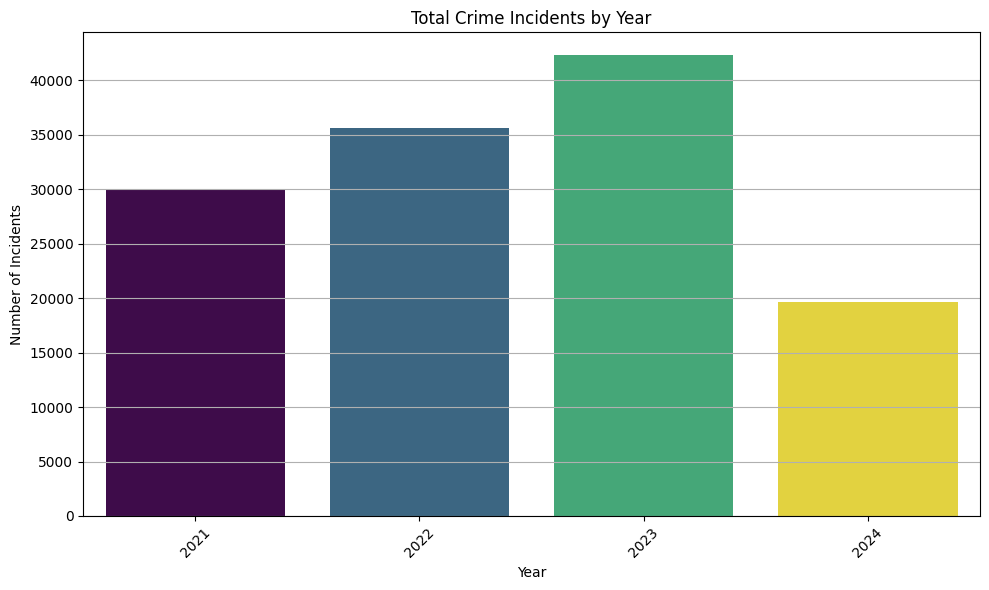

In [69]:
# Aggregate the data by year
crime_by_year = crime_by_month_year_hood.groupby('OCC_YEAR')['Total_Count'].sum().reset_index(name='Incident_Count')

# Plotting the total crime incidents by year
plt.figure(figsize=(10, 6))
sns.barplot(data=crime_by_year, x='OCC_YEAR', y='Incident_Count', hue='OCC_YEAR', palette='viridis', legend=False)

plt.title('Total Crime Incidents by Year')
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

[back to the top](#0)

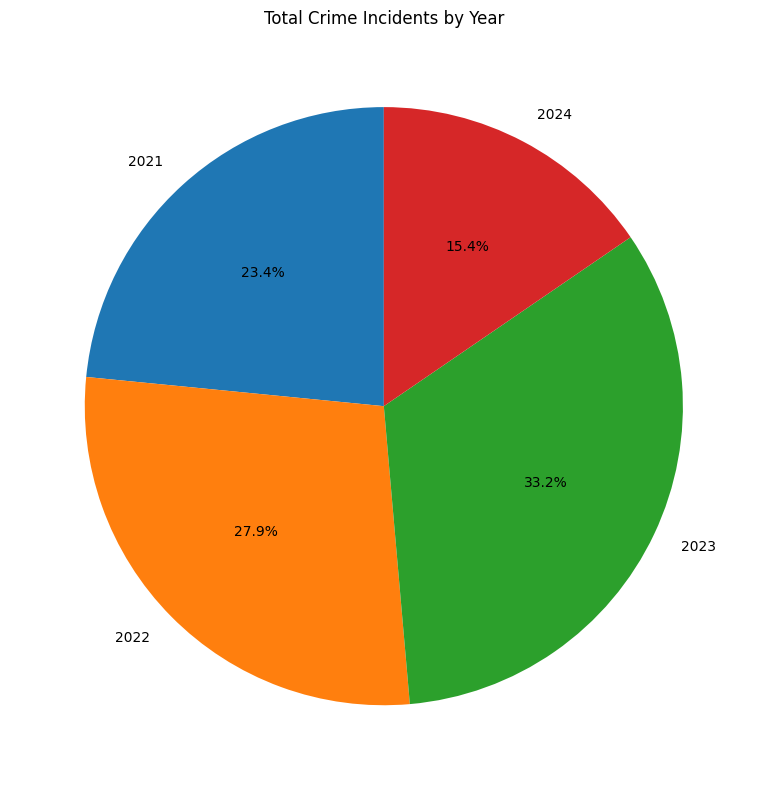

In [70]:
# Plotting the total crime incidents by year (Pie chart)
plt.figure(figsize=(8, 8))

# Generate colors using viridis colormap
plt.pie(crime_by_year['Incident_Count'], labels=crime_by_year['OCC_YEAR'], autopct='%1.1f%%', startangle=90)
plt.title('Total Crime Incidents by Year')
plt.tight_layout()
plt.show()

<a id="5.1.2"></a>
#### Crime Statistics for Previous Years with a Month Breakdown

[back to the top](#0)

In [71]:
crime_by_month_year_hood = crime_by_month_year_hood_copy.copy()

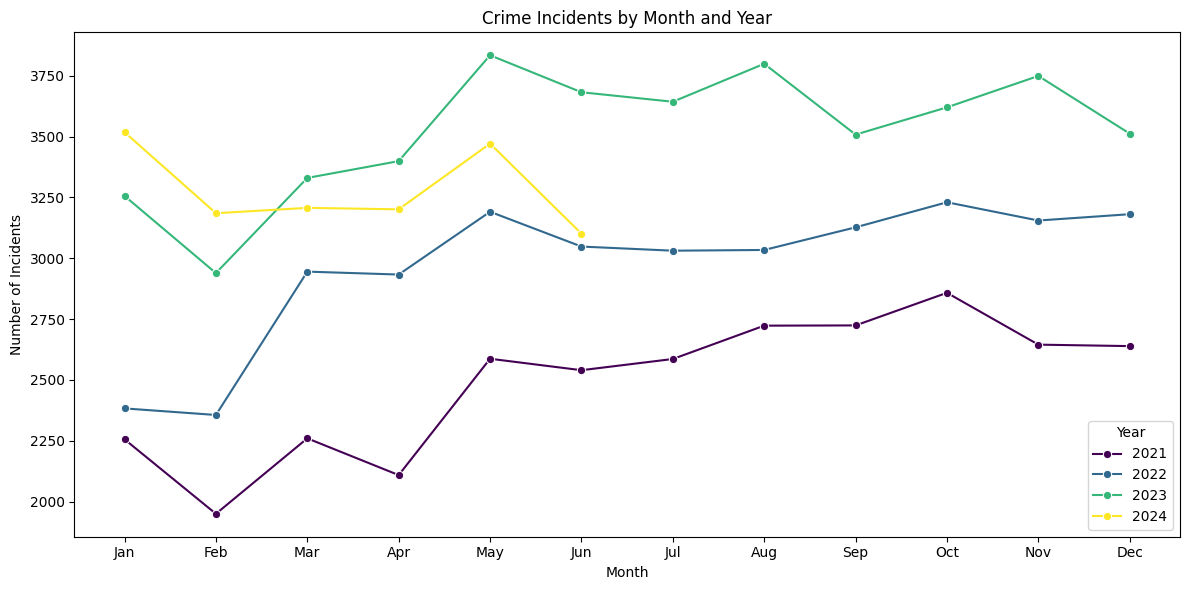

In [72]:
# Grouping by year and month, and calculating the total number of incidents
crime_by_month_year = crime_by_month_year_hood.groupby(['OCC_YEAR', 'OCC_MONTH'])['Total_Count'].sum().reset_index(name='Incident_Count')
# Plotting the line plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=crime_by_month_year, x='OCC_MONTH', y='Incident_Count', hue='OCC_YEAR', marker='o', palette='viridis')

plt.title('Crime Incidents by Month and Year')
plt.xlabel('Month')
plt.ylabel('Number of Incidents')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.legend(title='Year')
plt.tight_layout()
plt.show()


[back to the top](#0)

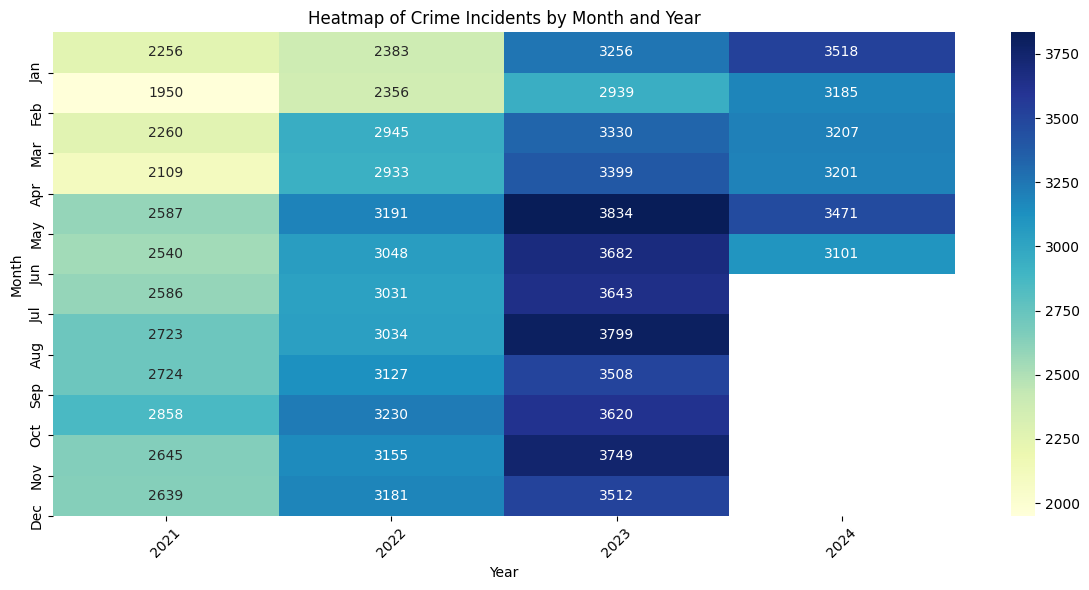

In [73]:
# Grouping by year and month, and calculating the total number of incidents
crime_by_month_year = crime_by_month_year_hood.groupby(['OCC_YEAR', 'OCC_MONTH'])['Total_Count'].sum().reset_index(name='Incident_Count')

# Filter for the year
#crime_2024_df = crime_by_month_year[crime_by_month_year['OCC_YEAR'] == 2024]
crime_filtered_df = crime_by_month_year[crime_by_month_year['OCC_YEAR'].isin([2021, 2022, 2023, 2024])]
# Grouping by year and month and pivoting to create a heatmap format
crime_by_month_year_pivot = crime_filtered_df.pivot_table(index='OCC_MONTH', columns='OCC_YEAR', values='Incident_Count', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(crime_by_month_year_pivot, cmap='YlGnBu', annot=True, fmt='.0f')

plt.title('Heatmap of Crime Incidents by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.yticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

In [74]:
# Step 1: Filter for 2025,2026 and 2027
crime_2021 = crime_by_month_year[crime_by_month_year['OCC_YEAR']== 2021]
crime_2022 = crime_by_month_year[crime_by_month_year['OCC_YEAR']== 2022]
crime_2023 = crime_by_month_year[crime_by_month_year['OCC_YEAR']== 2023]

<a id="5.1.3"></a>
#### Crime Statistics for 2021

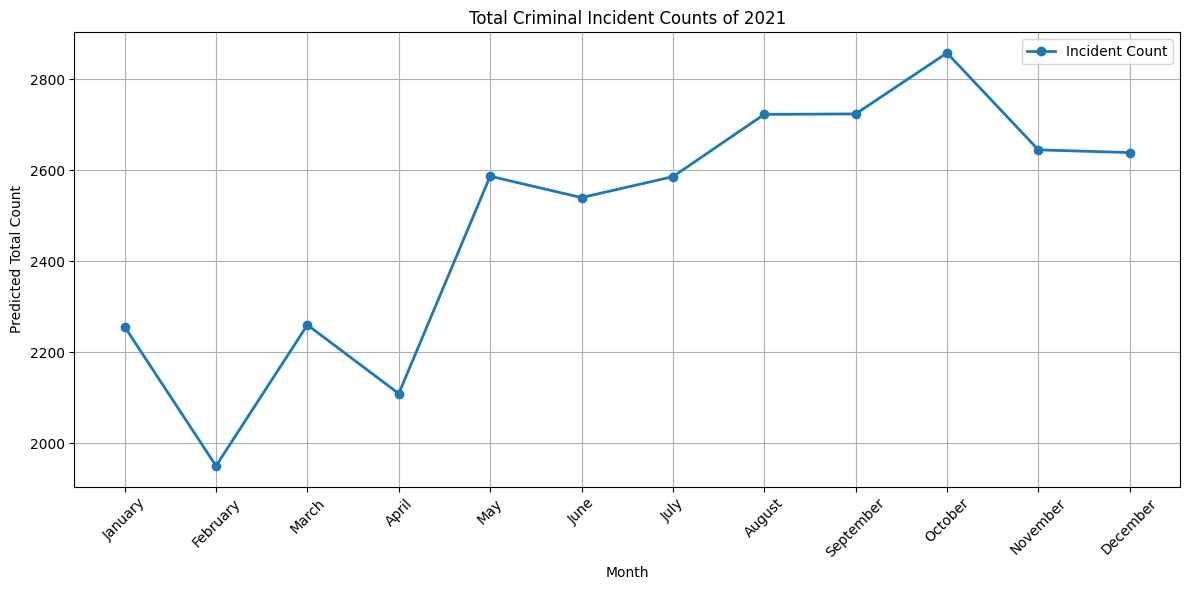

In [75]:
# Create a list of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2021['OCC_MONTH'],
         crime_2021['Incident_Count'],
         linewidth=2, marker='o', label='Incident Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Total Criminal Incident Counts of 2021')

# Set x-ticks to the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)

plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [76]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2021. Group crime_by_M_Y_H by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Count by summing it. Sort the groupby by the Total_Count column in descending order. Then filter the groupby to include just the first five rows

# Filter crime_by_M_Y_H to include only rows where OCC_YEAR is 2021
crime_2021 = crime_by_M_Y_H[crime_by_M_Y_H['OCC_YEAR'] == 2021]

# Group by NEIGHBOURHOOD_158 and OCC_YEAR, and sum Total_Count
crime_groupby = crime_2021.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Count'].sum().reset_index(name='Total_Count')

# Sort by Total_Count in descending order
crime_groupby_sorted = crime_groupby.sort_values('Total_Count', ascending=False)

# Filter to include just the first five rows
top_5_neighborhoods_2021 = crime_groupby_sorted.head(5)

top_5_neighborhoods_2021

NEIGHBOURHOOD_158  OCC_YEAR  Total_Count
139              West Humber-Clairville (1)      2021          849
93                           Moss Park (73)      2021          778
36                Downtown Yonge East (168)      2021          774
156            York University Heights (27)      2021          562
125  St Lawrence-East Bayfront-The Islands       2021          527

In [127]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2021 and NEIGHBOURHOOD_158 has the values in the top_5_neighborhoods_2021['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Count column for each neighbourhood and for each month in OCC_MONTH

# Filter crime_by_M_Y_H for 2021 and top 5 neighborhoods
crime_2021_top5 = crime_by_M_Y_H[
    (crime_by_M_Y_H['OCC_YEAR'] == 2021) &
    (crime_by_M_Y_H['NEIGHBOURHOOD_158'].isin(top_5_neighborhoods_2021['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Count
crime_2021_top5_grouped = crime_2021_top5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2021_top5_grouped,
    x='OCC_MONTH',
    y='Total_Count',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Count values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Count values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = top_5_neighborhoods_2021.loc[top_5_neighborhoods_2021['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Count'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Top 5 Neighborhoods for 2021')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

In [79]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2021. Group crime_by_M_Y_H by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Count by summing it. Sort the groupby by the Total_Count column in ascending order. Then filter the groupby to include just the first five rows.

# Filter crime_by_M_Y_H to only include rows where OCC_YEAR is 2021
crime_2021 = crime_by_M_Y_H[crime_by_M_Y_H['OCC_YEAR'] == 2021]

# Group by NEIGHBOURHOOD_158 and OCC_YEAR, and sum Total_Count
crime_groupby = crime_2021.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Count'].sum().reset_index(name='Total_Count')

# Sort by Total_Count in ascending order
crime_groupby_sorted = crime_groupby.sort_values('Total_Count', ascending=True)

# Filter to include just the first five rows
low_5_neighborhoods_2021 = crime_groupby_sorted.head(5)

low_5_neighborhoods_2021

NEIGHBOURHOOD_158  OCC_YEAR  Total_Count
78   Lambton Baby Point (114)      2021           42
56            Guildwood (140)      2021           48
150     Woodbine-Lumsden (60)      2021           51
113   Princess-Rosethorn (10)      2021           54
88         Markland Wood (12)      2021           58

In [128]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2021 and NEIGHBOURHOOD_158 has the values in the low_5_neighborhoods_2021['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Count column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Count values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Count value in low_5_neighborhoods_2021 Dataframe

# Filter crime_by_M_Y_H for 2021 and the neighborhoods in low_5_neighborhoods_2021
crime_2021_low5 = crime_by_M_Y_H[
    (crime_by_M_Y_H['OCC_YEAR'] == 2021) &
    (crime_by_M_Y_H['NEIGHBOURHOOD_158'].isin(low_5_neighborhoods_2021['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Count
crime_2021_low5_grouped = crime_2021_low5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2021_low5_grouped,
    x='OCC_MONTH',
    y='Total_Count',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Count values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Count values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = low_5_neighborhoods_2021.loc[low_5_neighborhoods_2021['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Count'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Low 5 Neighborhoods for 2021')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

<a id="5.1.4"></a>
#### Crime Statistics for 2022

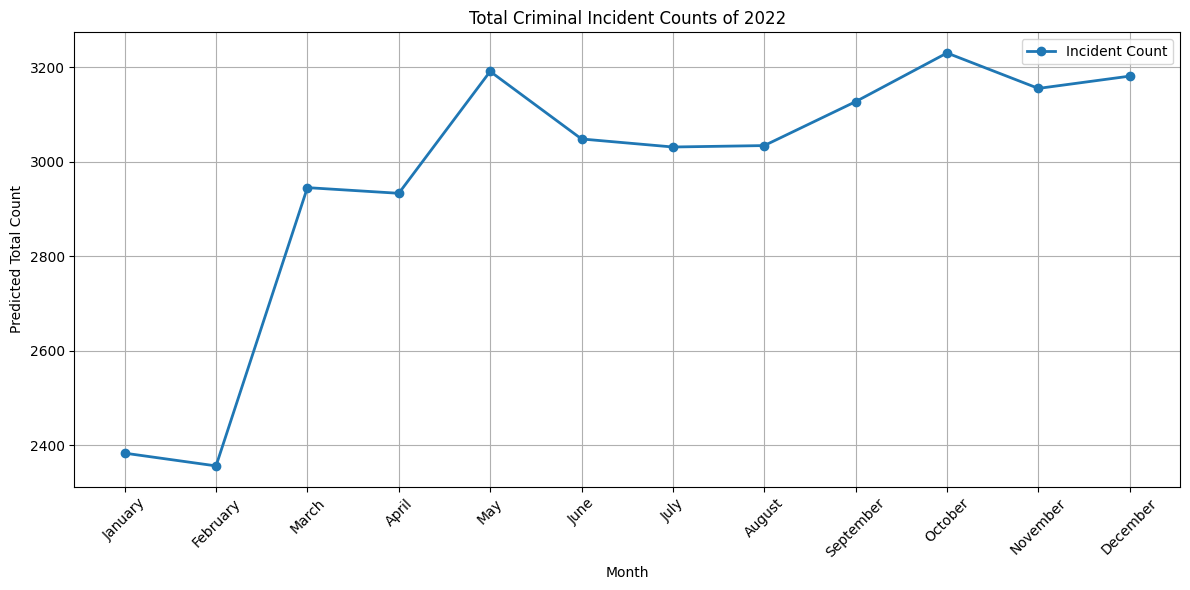

In [82]:
# Create a list of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2022['OCC_MONTH'],
         crime_2022['Incident_Count'],
         linewidth=2, marker='o', label='Incident Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Total Criminal Incident Counts of 2022')

# Set x-ticks to the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)

plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [83]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2022. Group crime_by_M_Y_H by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Count by summing it. Sort the groupby by the Total_Count column in descending order. Then filter the groupby to include just the first five rows

# Filter crime_by_M_Y_H to only include rows where OCC_YEAR is 2022
crime_2022 = crime_by_M_Y_H[crime_by_M_Y_H['OCC_YEAR'] == 2022]

# Group by NEIGHBOURHOOD_158 and OCC_YEAR, and sum Total_Count
crime_groupby = crime_2022.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Count'].sum().reset_index(name='Total_Count')

# Sort by Total_Count in descending order
crime_groupby_sorted = crime_groupby.sort_values('Total_Count', ascending=False)

# Filter to include just the first five rows
top_5_neighborhoods_2022 = crime_groupby_sorted.head(5)

# Print or use the result as needed
top_5_neighborhoods_2022

NEIGHBOURHOOD_158  OCC_YEAR  Total_Count
139    West Humber-Clairville (1)      2022         1146
93                 Moss Park (73)      2022          702
156  York University Heights (27)      2022          694
36      Downtown Yonge East (168)      2022          690
152      Yonge-Bay Corridor (170)      2022          604

In [129]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2022 and NEIGHBOURHOOD_158 has the values in the top_5_neighborhoods_2022['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Count column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Count values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Count value in top_5_neighborhoods_2022 Dataframe

# Filter crime_by_M_Y_H for 2022 and top 5 neighborhoods
crime_2022_top5 = crime_by_M_Y_H[
    (crime_by_M_Y_H['OCC_YEAR'] == 2022) &
    (crime_by_M_Y_H['NEIGHBOURHOOD_158'].isin(top_5_neighborhoods_2022['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Count
crime_2022_top5_grouped = crime_2022_top5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2022_top5_grouped,
    x='OCC_MONTH',
    y='Total_Count',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Count values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Count values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = top_5_neighborhoods_2022.loc[top_5_neighborhoods_2022['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Count'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Top 5 Neighborhoods for 2022')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

In [86]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2022. Group crime_by_M_Y_H by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Count by summing it. Sort the groupby by the Total_Count column in ascending order. Then filter the groupby to include just the first five rows

# Filter crime_by_M_Y_H to only include rows where OCC_YEAR is 2022
crime_2022 = crime_by_M_Y_H[crime_by_M_Y_H['OCC_YEAR'] == 2022]

# Group by NEIGHBOURHOOD_158 and OCC_YEAR, and sum Total_Count
crime_groupby = crime_2022.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Count'].sum().reset_index(name='Total_Count')

# Sort by Total_Count in ascending order
crime_groupby_sorted = crime_groupby.sort_values('Total_Count', ascending=True)

# Filter to include just the first five rows
low_5_neighborhoods_2022 = crime_groupby_sorted.head(5)

low_5_neighborhoods_2022

NEIGHBOURHOOD_158  OCC_YEAR  Total_Count
56                Guildwood (140)      2022           53
9      Bayview Woods-Steeles (49)      2022           59
150         Woodbine-Lumsden (60)      2022           67
4                  Avondale (153)      2022           70
64   Humber Heights-Westmount (8)      2022           73

In [130]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2022 and NEIGHBOURHOOD_158 has the values in the low_5_neighborhoods_2022['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Count column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Count values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Count value in low_5_neighborhoods_2022 Dataframe

# Filter crime_by_M_Y_H for 2022 and the neighborhoods in low_5_neighborhoods_2022
crime_2022_low5 = crime_by_M_Y_H[
    (crime_by_M_Y_H['OCC_YEAR'] == 2022) &
    (crime_by_M_Y_H['NEIGHBOURHOOD_158'].isin(low_5_neighborhoods_2022['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Count
crime_2022_low5_grouped = crime_2022_low5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2022_low5_grouped,
    x='OCC_MONTH',
    y='Total_Count',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Count values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Count values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = low_5_neighborhoods_2022.loc[low_5_neighborhoods_2022['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Count'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Low 5 Neighborhoods for 2022')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

<a id="5.1.5"></a>
#### Crime Statistics for 2023

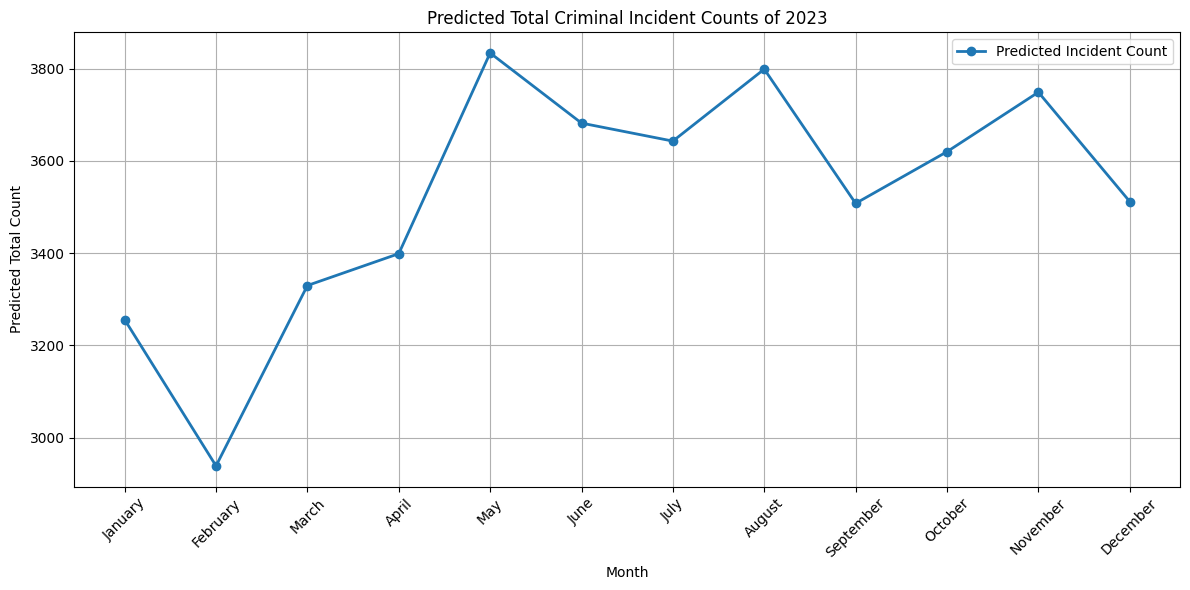

In [89]:
# Create a list of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2023['OCC_MONTH'],
         crime_2023['Incident_Count'],
         linewidth=2, marker='o', label='Predicted Incident Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Criminal Incident Counts of 2023')

# Set x-ticks to the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)

plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [90]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2023. Group crime_by_M_Y_H by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Count by summing it. Sort the groupby by the Total_Count column in descending order. Then filter the groupby to include just the first five rows

# Filter crime_by_M_Y_H to only include rows where OCC_YEAR is 2023
crime_2023 = crime_by_M_Y_H[crime_by_M_Y_H['OCC_YEAR'] == 2023]

# Group by NEIGHBOURHOOD_158 and OCC_YEAR, and sum Total_Count
crime_groupby = crime_2023.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Count'].sum().reset_index(name='Total_Count')

# Sort by Total_Count in descending order
crime_groupby_sorted = crime_groupby.sort_values('Total_Count', ascending=False)

# Filter to include just the first five rows
top_5_neighborhoods_2023 = crime_groupby_sorted.head(5)

top_5_neighborhoods_2023

NEIGHBOURHOOD_158  OCC_YEAR  Total_Count
139    West Humber-Clairville (1)      2023         1371
156  York University Heights (27)      2023          847
36      Downtown Yonge East (168)      2023          790
93                 Moss Park (73)      2023          770
152      Yonge-Bay Corridor (170)      2023          717

In [131]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2023 and NEIGHBOURHOOD_158 has the values in the top_5_neighborhoods_2023['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Count column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Count values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Count value in top_5_neighborhoods_2023 Dataframe

# Filter crime_by_M_Y_H for 2023 and top 5 neighborhoods
crime_2023_top5 = crime_by_M_Y_H[
    (crime_by_M_Y_H['OCC_YEAR'] == 2023) &
    (crime_by_M_Y_H['NEIGHBOURHOOD_158'].isin(top_5_neighborhoods_2023['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Count
crime_2023_top5_grouped = crime_2023_top5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2023_top5_grouped,
    x='OCC_MONTH',
    y='Total_Count',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Count values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Count values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = top_5_neighborhoods_2023.loc[top_5_neighborhoods_2023['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Count'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Top 5 Neighborhoods for 2023')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

In [93]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2023. Group crime_by_M_Y_H by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Count by summing it. Sort the groupby by the Total_Count column in ascending order. Then filter the groupby to include just the first five rows

# Filter crime_by_M_Y_H to only include rows where OCC_YEAR is 2023
crime_2023 = crime_by_M_Y_H[crime_by_M_Y_H['OCC_YEAR'] == 2023]

# Group by NEIGHBOURHOOD_158 and OCC_YEAR, and sum Total_Count
crime_groupby = crime_2023.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Count'].sum().reset_index(name='Total_Count')

# Sort by Total_Count in ascending order
crime_groupby_sorted = crime_groupby.sort_values('Total_Count', ascending=True)

# Filter to include just the first five rows
low_5_neighborhoods_2023 = crime_groupby_sorted.head(5)

low_5_neighborhoods_2023

NEIGHBOURHOOD_158  OCC_YEAR  Total_Count
150         Woodbine-Lumsden (60)      2023           58
78       Lambton Baby Point (114)      2023           68
56                Guildwood (140)      2023           83
64   Humber Heights-Westmount (8)      2023           83
88             Markland Wood (12)      2023           96

In [132]:
# prompt: Filter crime_by_M_Y_H to only include rows in which OCC_YEAR column has the value 2023 and NEIGHBOURHOOD_158 has the values in the low_5_neighborhoods_2023['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Count column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Count values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Count value in low_5_neighborhoods_2023 Dataframe

# Filter crime_by_M_Y_H for 2023 and the neighborhoods in low_5_neighborhoods_2023
crime_2023_low5 = crime_by_M_Y_H[
    (crime_by_M_Y_H['OCC_YEAR'] == 2023) &
    (crime_by_M_Y_H['NEIGHBOURHOOD_158'].isin(low_5_neighborhoods_2023['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Count
crime_2023_low5_grouped = crime_2023_low5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Count'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2023_low5_grouped,
    x='OCC_MONTH',
    y='Total_Count',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Count values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Count values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = low_5_neighborhoods_2023.loc[low_5_neighborhoods_2023['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Count'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Low 5 Neighborhoods for 2023')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

<a id="5.1.6"></a>
#### Comparison of Actual Data and the Predicted Data of 2024

[back to the top](#0)

In [96]:
# prompt: Create a dataframe with just the data for the year 2024 and concatenate y_voting_TC_pred values onto it in a column named Predicted_Total_Count

predicted_crime_2024 = crime_by_M_Y_H.loc[crime_by_M_Y_H['OCC_YEAR'] == 2024, :]

# Concatenate the predictions onto the DataFrame
predicted_crime_2024.loc[: , 'Predicted_Total_Count'] = y_voting_TC_pred

# Round the values in Predicted_Total_Count to zero decimal places and convert the column to integers
predicted_crime_2024.loc[: , 'Predicted_Total_Count'] = predicted_crime_2024['Predicted_Total_Count'].round(0).astype(int)

# Drop the Assault, Auto Theft, Break and Enter, Robbery, Theft Over columns from the Dataframe
predicted_crime_2024 = predicted_crime_2024.drop(columns=['Assault', 'Auto Theft', 'Break and Enter', 'Robbery', 'Theft Over'])

# Now df_2024 contains the data for 2024 with a new column 'Predicted_Total_Count'
predicted_crime_2024

<ipython-input-96-525f6f4de7e7>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_crime_2024.loc[: , 'Predicted_Total_Count'] = y_voting_TC_pred


NEIGHBOURHOOD_158  HOOD_158  OCC_YEAR  OCC_MONTH  \
36         West Humber-Clairville (1)         1      2024          1   
37         West Humber-Clairville (1)         1      2024          2   
38         West Humber-Clairville (1)         1      2024          3   
39         West Humber-Clairville (1)         1      2024          4   
40         West Humber-Clairville (1)         1      2024          5   
...                               ...       ...       ...        ...   
6630  South Eglinton-Davisville (174)       174      2024          2   
6631  South Eglinton-Davisville (174)       174      2024          3   
6632  South Eglinton-Davisville (174)       174      2024          4   
6633  South Eglinton-Davisville (174)       174      2024          5   
6634  South Eglinton-Davisville (174)       174      2024          6   

      Total_Count  Predicted_Total_Count  
36            110                  113.0  
37            101                  108.0  
38             79                  110.0  
39             93                  110.0  
40            104                  110.0  
...           ...                    ...  
6630           15                   11.0  
6631            7                   14.0  
6632           17                   13.0  
6633           12                   13.0  
6634           13                   12.0  

[948 rows x 6 columns]

[back to the top](#0)

   OCC_MONTH  Total_Count  Predicted_Total_Count
0          1         3518                 3189.0
1          2         3185                 3008.0
2          3         3207                 3340.0
3          4         3201                 3406.0
4          5         3471                 3732.0
5          6         3101                 3676.0


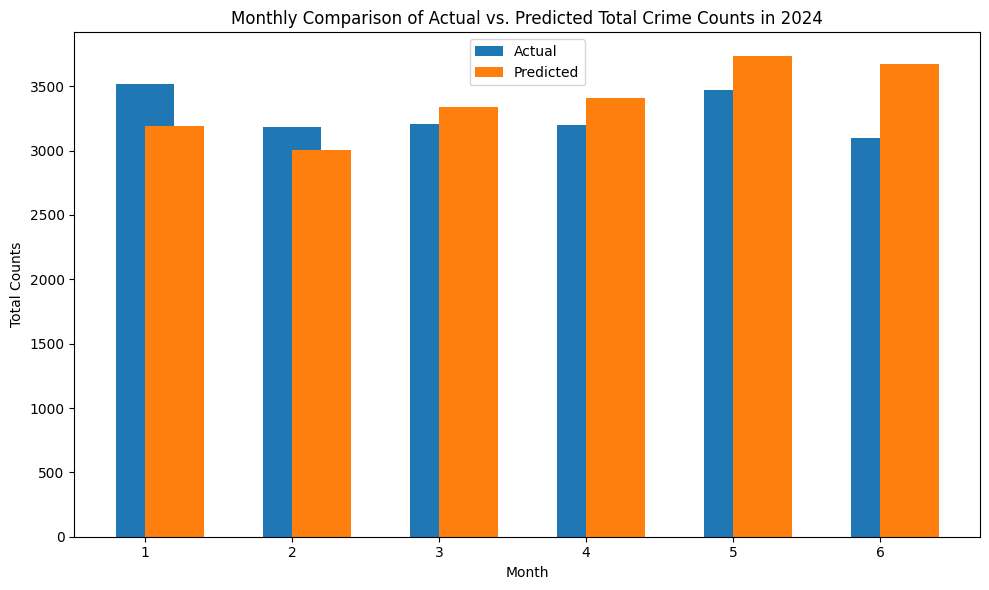

In [97]:
# Group by OCC_MONTH and calculate the sum for Actual_Total and Predicted_Total
monthly_comparison_2024 = predicted_crime_2024.groupby('OCC_MONTH')[['Total_Count', 'Predicted_Total_Count']].sum().reset_index()

# Display the grouped DataFrame
print(monthly_comparison_2024)

# Plotting the results

plt.figure(figsize=(10, 6))
plt.bar(monthly_comparison_2024['OCC_MONTH'], monthly_comparison_2024['Total_Count'], width=0.4, label='Actual', align='center')
plt.bar(monthly_comparison_2024['OCC_MONTH'], monthly_comparison_2024['Predicted_Total_Count'], width=0.4, label='Predicted', align='edge')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Total Counts')
plt.title('Monthly Comparison of Actual vs. Predicted Total Crime Counts in 2024')
plt.xticks(monthly_comparison_2024['OCC_MONTH'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


<a id="5.2"></a>
### Visualizations based on the Predictions

[back to the top](#0)

In [98]:
# prompt: Show all the unique values in 'OCC_MONTH' column of predicted_crime_2024

# All the months for which there is crime data for the year 2024
unique_occ_month = predicted_crime_2024['OCC_MONTH'].unique()

unique_occ_month

array([1, 2, 3, 4, 5, 6])

[back to the top](#0)

In [99]:
# prompt: Make a copy of crime_by_M_Y_H with just the four starting columns. Change the value 2021 in the 'OCC_YEAR' column to 2025, the value 2022 to 2026, and 2023 to 2027. Change the value 1 in the 'OCC_MONTH to 7, 2 to 8, 3 to 9, 4 to 10, 5 to 11, and 6 to 12, whenever the value in the 'OCC_YEAR' column is 2024. Order the dataframe by the 'HOOD_158' and 'OCC_YEAR' columns.

crime_by_M_Y_H_copy = crime_by_M_Y_H.iloc[:, :4].copy()

# Replace values in 'OCC_YEAR' column
crime_by_M_Y_H_copy.loc[crime_by_M_Y_H_copy['OCC_YEAR'] == 2021, 'OCC_YEAR'] = 2025
crime_by_M_Y_H_copy.loc[crime_by_M_Y_H_copy['OCC_YEAR'] == 2022, 'OCC_YEAR'] = 2026
crime_by_M_Y_H_copy.loc[crime_by_M_Y_H_copy['OCC_YEAR'] == 2023, 'OCC_YEAR'] = 2027

# Replace values in 'OCC_MONTH' column for year 2024
crime_by_M_Y_H_copy.loc[(crime_by_M_Y_H_copy['OCC_YEAR'] == 2024) & (crime_by_M_Y_H_copy['OCC_MONTH'] == 1), 'OCC_MONTH'] = 7
crime_by_M_Y_H_copy.loc[(crime_by_M_Y_H_copy['OCC_YEAR'] == 2024) & (crime_by_M_Y_H_copy['OCC_MONTH'] == 2), 'OCC_MONTH'] = 8
crime_by_M_Y_H_copy.loc[(crime_by_M_Y_H_copy['OCC_YEAR'] == 2024) & (crime_by_M_Y_H_copy['OCC_MONTH'] == 3), 'OCC_MONTH'] = 9
crime_by_M_Y_H_copy.loc[(crime_by_M_Y_H_copy['OCC_YEAR'] == 2024) & (crime_by_M_Y_H_copy['OCC_MONTH'] == 4), 'OCC_MONTH'] = 10
crime_by_M_Y_H_copy.loc[(crime_by_M_Y_H_copy['OCC_YEAR'] == 2024) & (crime_by_M_Y_H_copy['OCC_MONTH'] == 5), 'OCC_MONTH'] = 11
crime_by_M_Y_H_copy.loc[(crime_by_M_Y_H_copy['OCC_YEAR'] == 2024) & (crime_by_M_Y_H_copy['OCC_MONTH'] == 6), 'OCC_MONTH'] = 12

# Order the DataFrame
future_crime_predictions = crime_by_M_Y_H_copy.sort_values(['HOOD_158', 'OCC_YEAR'])

# Now future_crime_predictions contains the modified DataFrame with index values reset as well
future_crime_predictions = future_crime_predictions.reset_index(drop=True)
future_crime_predictions

NEIGHBOURHOOD_158  HOOD_158  OCC_YEAR  OCC_MONTH
0          West Humber-Clairville (1)         1      2024          7
1          West Humber-Clairville (1)         1      2024          8
2          West Humber-Clairville (1)         1      2024          9
3          West Humber-Clairville (1)         1      2024         10
4          West Humber-Clairville (1)         1      2024         11
...                               ...       ...       ...        ...
6630  South Eglinton-Davisville (174)       174      2027          8
6631  South Eglinton-Davisville (174)       174      2027          9
6632  South Eglinton-Davisville (174)       174      2027         10
6633  South Eglinton-Davisville (174)       174      2027         11
6634  South Eglinton-Davisville (174)       174      2027         12

[6635 rows x 4 columns]

[back to the top](#0)

In [100]:
# prompt: Make a copy of the future_crime_predictions with just the 'HOOD_158',  'OCC_YEAR', 'OCC_MONTH' columns, and use that dataframe to make new predictions with the best_voting_model_TC and then concatenate those predictions onto future_crime_predictions under the column Total_Counts

# Create a copy of future_crime_predictions with only the feature columns
future_crime_predictions_subset = future_crime_predictions[['HOOD_158', 'OCC_YEAR', 'OCC_MONTH']].copy()

# Make predictions using the best_voting_model_TC
new_predictions = best_voting_model_TC.predict(future_crime_predictions_subset)

# Concatenate the new predictions onto the future_crime_predictions DataFrame
future_crime_predictions['Total_Counts'] = new_predictions

# Round the values in the Total_Counts to zero decimal places and convert the values to integers
future_crime_predictions['Total_Counts'] = future_crime_predictions['Total_Counts'].round(0).astype(int)

# Display the updated future_crime_predictions DataFrame
future_crime_predictions

NEIGHBOURHOOD_158  HOOD_158  OCC_YEAR  OCC_MONTH  \
0          West Humber-Clairville (1)         1      2024          7   
1          West Humber-Clairville (1)         1      2024          8   
2          West Humber-Clairville (1)         1      2024          9   
3          West Humber-Clairville (1)         1      2024         10   
4          West Humber-Clairville (1)         1      2024         11   
...                               ...       ...       ...        ...   
6630  South Eglinton-Davisville (174)       174      2027          8   
6631  South Eglinton-Davisville (174)       174      2027          9   
6632  South Eglinton-Davisville (174)       174      2027         10   
6633  South Eglinton-Davisville (174)       174      2027         11   
6634  South Eglinton-Davisville (174)       174      2027         12   

      Total_Counts  
0              111  
1              111  
2              108  
3              110  
4              107  
...            ...  
6630            12  
6631            13  
6632            14  
6633            14  
6634            15  

[6635 rows x 5 columns]

<a id="5.2.1"></a>
#### Anticipated Crime Statistics for next six months of 2024

In [101]:
# Grouping 2024 data by month
crime_2024_2nd_half = future_crime_predictions.loc[future_crime_predictions['OCC_YEAR']==2024, :].groupby('OCC_MONTH')['Total_Counts'].sum().reset_index()

[back to the top](#0)

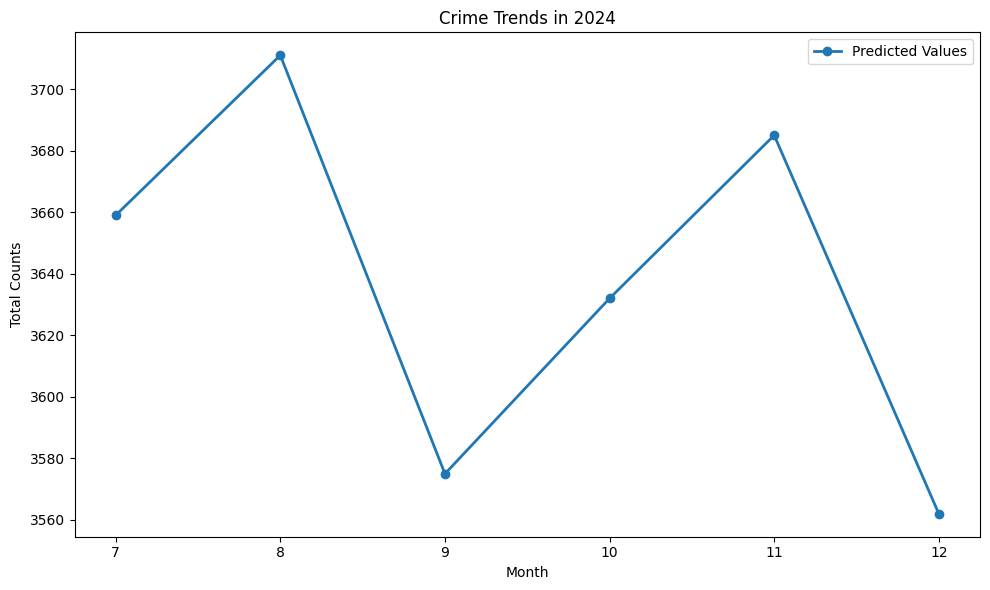

In [102]:
# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(crime_2024_2nd_half['OCC_MONTH'], crime_2024_2nd_half['Total_Counts'], linewidth=2, label='Predicted Values', marker='o')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Total Counts')
plt.title('Crime Trends in 2024')
plt.xticks(crime_2024_2nd_half['OCC_MONTH'])
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

<a id="5.2.2"></a>
#### Anticipated Total count of Crime Acitivities for upcoming three years

[back to the top](#0)

In [103]:
# Filtering just the 2025-2027 data
crime_2025_2027 = future_crime_predictions[future_crime_predictions['OCC_YEAR'].isin([2025, 2026, 2027])].copy()

# Grouping by 'OCC_YEAR' and calculating the mean of 'Total_Counts'
crime_2025_2027_total = crime_2025_2027.groupby('OCC_YEAR')['Total_Counts'].sum().reset_index()

# Displaying the result
crime_2025_2027_total


OCC_YEAR  Total_Counts
0      2025         42175
1      2026         42175
2      2027         42167

[back to the top](#0)

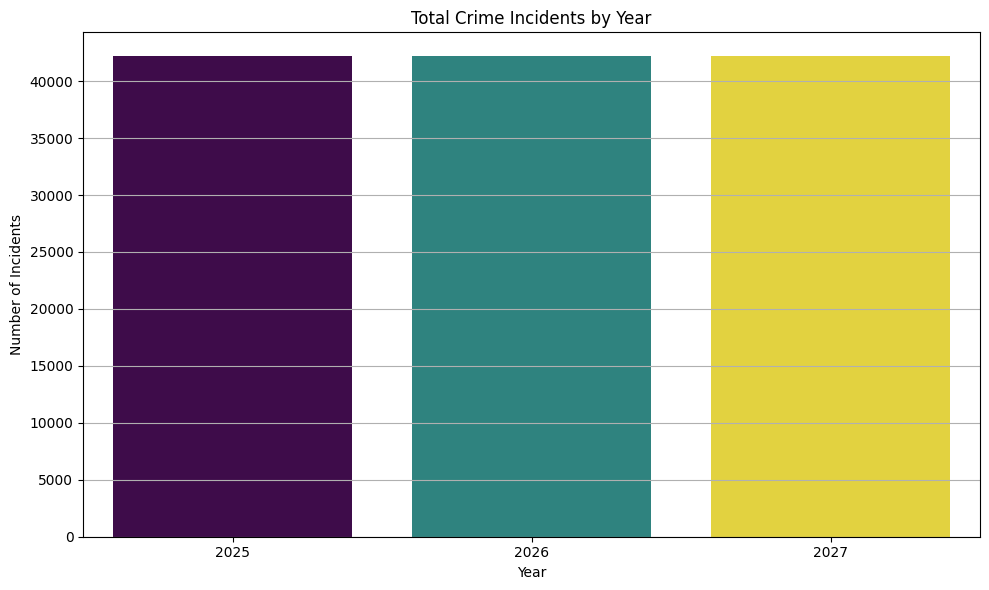

In [104]:
# Plotting the results
plt.figure(figsize=(10, 6))
sns.barplot(data=crime_2025_2027_total, x='OCC_YEAR', y='Total_Counts', hue='OCC_YEAR', palette='viridis', legend=False)
# Add labels, title, and legend
plt.xlabel('Year')
plt.ylabel('Number of Incidents')
plt.title('Total Crime Incidents by Year')
plt.grid(axis='y')

# Show the plot
plt.tight_layout()
plt.show()

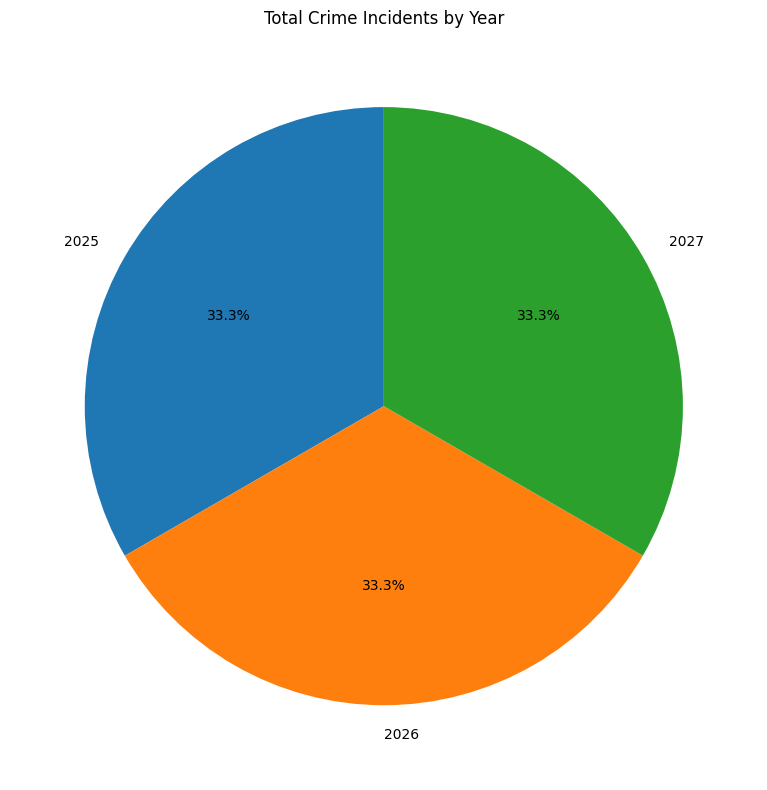

In [105]:
# Plotting the total crime incidents by year (Pie chart)
plt.figure(figsize=(8, 8))

# Generate colors using viridis colormap
plt.pie(crime_2025_2027_total['Total_Counts'], labels=crime_2025_2027_total['OCC_YEAR'], autopct='%1.1f%%', startangle=90)
plt.title('Total Crime Incidents by Year')
plt.tight_layout()
plt.show()

<a id="5.2.3"></a>
#### Anticipated Crime Statistics for Upcoming Year with a Month Breakdown

[back to the top](#0)

In [106]:
# Group the data by year and month and get the mean of Predicted_Total_Count
crime_by_future_year_month = crime_2025_2027.groupby(['OCC_YEAR', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()
crime_by_future_year_month

OCC_YEAR  OCC_MONTH  Total_Counts
0       2025          1          3189
1       2025          2          3008
2       2025          3          3340
3       2025          4          3406
4       2025          5          3732
5       2025          6          3676
6       2025          7          3659
7       2025          8          3711
8       2025          9          3575
9       2025         10          3632
10      2025         11          3685
11      2025         12          3562
12      2026          1          3189
13      2026          2          3008
14      2026          3          3340
15      2026          4          3406
16      2026          5          3732
17      2026          6          3676
18      2026          7          3659
19      2026          8          3711
20      2026          9          3575
21      2026         10          3632
22      2026         11          3685
23      2026         12          3562
24      2027          1          3189
25      2027          2          3008
26      2027          3          3332
27      2027          4          3406
28      2027          5          3732
29      2027          6          3676
30      2027          7          3659
31      2027          8          3711
32      2027          9          3575
33      2027         10          3632
34      2027         11          3685
35      2027         12          3562

[back to the top](#0)

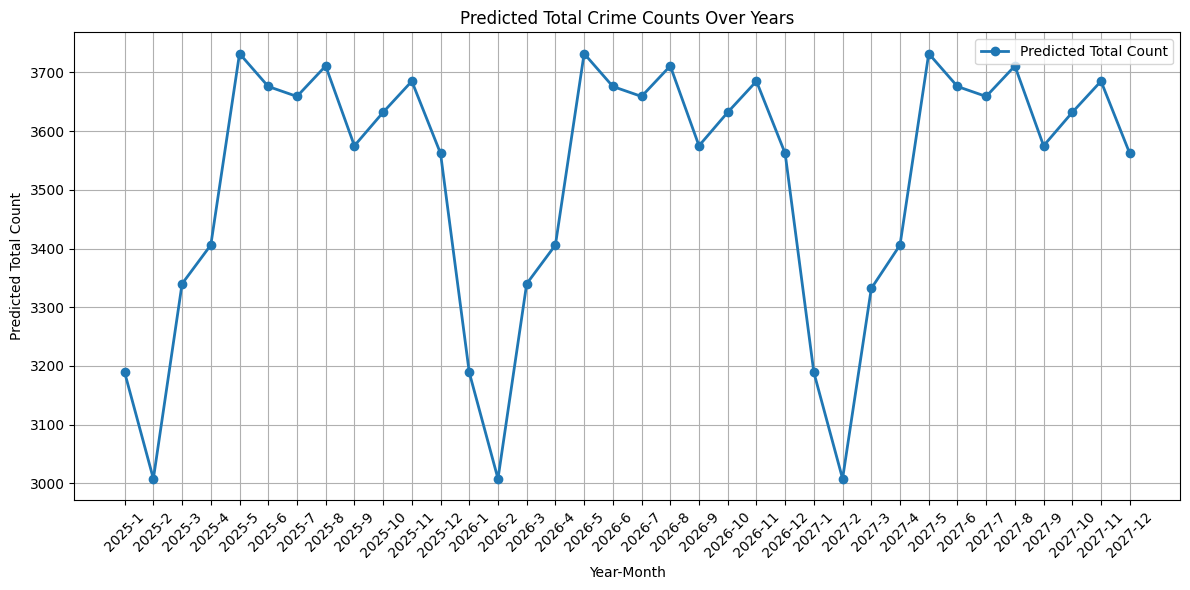

In [107]:
# Create a combined month-year column for plotting
crime_by_future_year_month['Year_Month'] = crime_by_future_year_month['OCC_YEAR'].astype(str) + '-' + crime_by_future_year_month['OCC_MONTH'].astype(str)

# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_by_future_year_month['Year_Month'],
         crime_by_future_year_month['Total_Counts'],
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Year-Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts Over Years')
plt.xticks(rotation=45)  # Rotate x-ticks for better readability
plt.grid(True)  # Optional: Add grid for better visibility
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

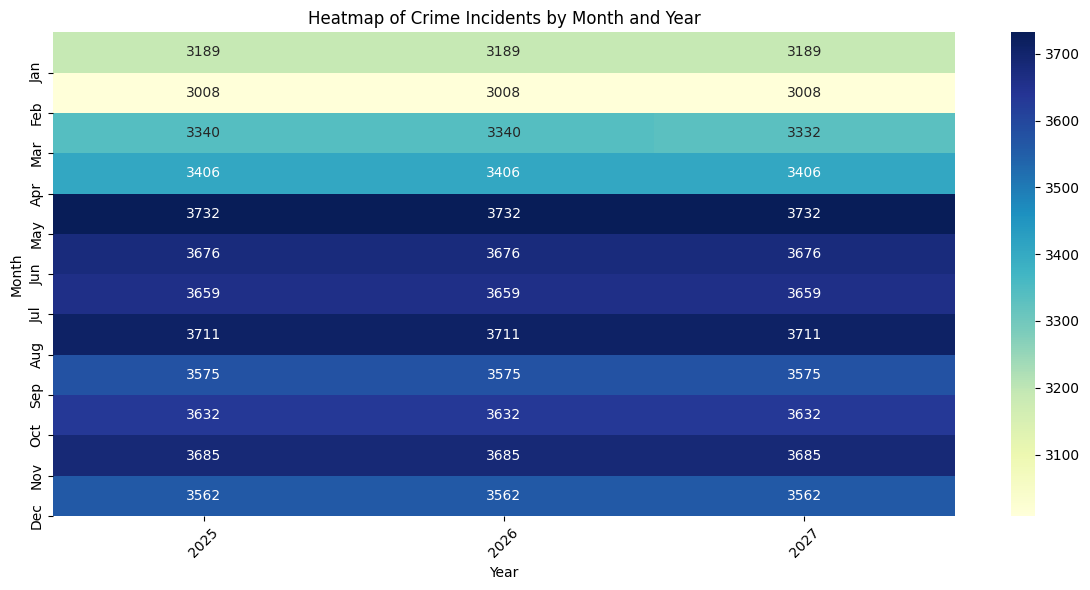

In [108]:
# Grouping by year and month and pivoting to create a heatmap format
crime_by_future_year_month_pivot = crime_by_future_year_month.pivot_table(index='OCC_MONTH', columns='OCC_YEAR', values='Total_Counts', aggfunc='sum')

# Plotting the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(crime_by_future_year_month_pivot, cmap='YlGnBu', annot=True, fmt='.0f')

plt.title('Heatmap of Crime Incidents by Month and Year')
plt.xlabel('Year')
plt.ylabel('Month')
plt.xticks(rotation=45)
plt.yticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

In [109]:
# Step 1: Filter for 2025,2026 and 2027
crime_2025 = crime_by_future_year_month[crime_by_future_year_month['OCC_YEAR']== 2025]
crime_2026 = crime_by_future_year_month[crime_by_future_year_month['OCC_YEAR']== 2026]
crime_2027 = crime_by_future_year_month[crime_by_future_year_month['OCC_YEAR']== 2027]

<a id="5.2.4"></a>
#### Anticipated Crime Statistics for 2025

[back to the top](#0)

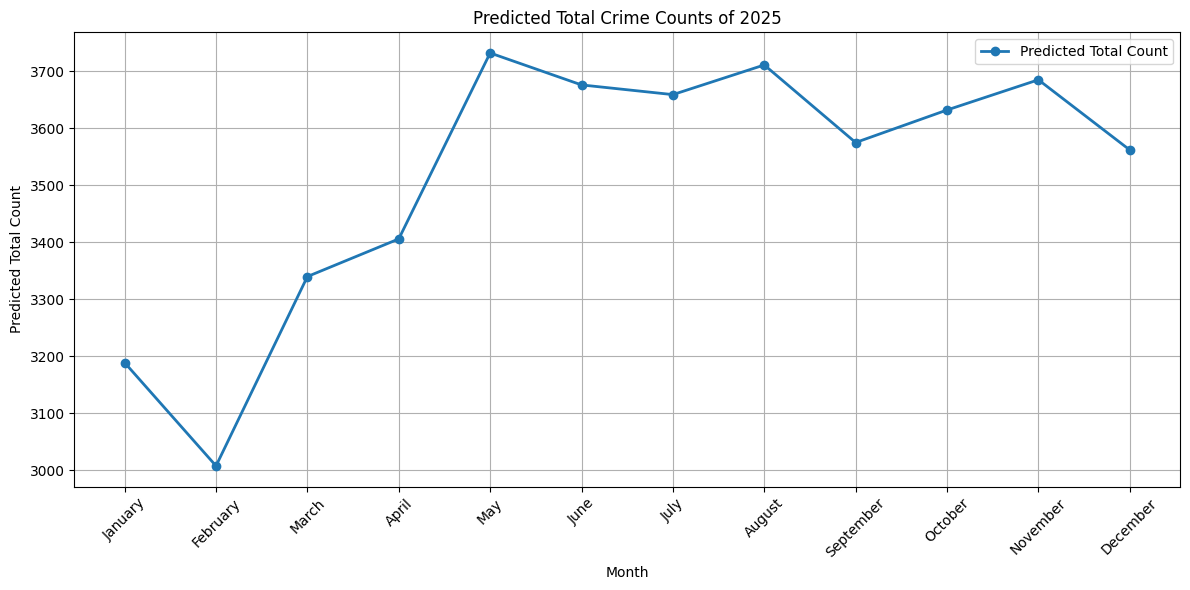

In [110]:
# Create a list of month names
month_names = [
    'January', 'February', 'March', 'April', 'May', 'June',
    'July', 'August', 'September', 'October', 'November', 'December'
]

# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2025['OCC_MONTH'],
         crime_2025['Total_Counts'],
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts of 2025')

# Set x-ticks to the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)

plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [111]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2025. Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it. Sort the groupby by the Total_Counts column in descending order. Then filter the groupby to include just the first five rows

# Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2025.
crime_2025 = crime_2025_2027[crime_2025_2027['OCC_YEAR'] == 2025]

# Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it.
crime_groupby = crime_2025.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Counts'].sum().reset_index(name='Total_Counts')

# Sort the groupby by the Total_Counts column in descending order.
crime_groupby_sorted = crime_groupby.sort_values('Total_Counts', ascending=False)

# Then filter the groupby to include just the first five rows
top_5_neighborhoods_2025 = crime_groupby_sorted.head(5)

top_5_neighborhoods_2025

NEIGHBOURHOOD_158  OCC_YEAR  Total_Counts
139    West Humber-Clairville (1)      2025          1322
156  York University Heights (27)      2025           789
36      Downtown Yonge East (168)      2025           760
93                 Moss Park (73)      2025           747
152      Yonge-Bay Corridor (170)      2025           679

In [112]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2025 and NEIGHBOURHOOD_158 has the values in the top_5_neighborhoods_2025['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Counts column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Counts values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Counts value in top_5_neighborhoods_2025 Dataframe

# Filter crime_2025_2027 for 2025 and top 5 neighborhoods
crime_2025_top5 = crime_2025_2027[
    (crime_2025_2027['OCC_YEAR'] == 2025) &
    (crime_2025_2027['NEIGHBOURHOOD_158'].isin(top_5_neighborhoods_2025['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Counts
crime_2025_top5_grouped = crime_2025_top5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2025_top5_grouped,
    x='OCC_MONTH',
    y='Total_Counts',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Counts values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Counts values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = top_5_neighborhoods_2025.loc[top_5_neighborhoods_2025['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Counts'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Top 5 Neighborhoods for 2025')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

In [113]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2025. Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it. Sort the groupby by the Total_Counts column in ascending order. Then filter the groupby to include just the first five rows

# Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2025.
crime_2025 = crime_2025_2027[crime_2025_2027['OCC_YEAR'] == 2025]

# Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it.
crime_groupby = crime_2025.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Counts'].sum().reset_index(name='Total_Counts')

# Sort the groupby by the Total_Counts column in ascending order.
crime_groupby_sorted = crime_groupby.sort_values('Total_Counts', ascending=True)

# Then filter the groupby to include just the first five rows
low_5_neighborhoods_2025 = crime_groupby_sorted.head(5)

low_5_neighborhoods_2025

NEIGHBOURHOOD_158  OCC_YEAR  Total_Counts
150         Woodbine-Lumsden (60)      2025            93
78       Lambton Baby Point (114)      2025            95
64   Humber Heights-Westmount (8)      2025           113
107            Old East York (58)      2025           113
19           Broadview North (57)      2025           115

In [114]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2025 and NEIGHBOURHOOD_158 has the values in the low_5_neighborhoods_2025['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Counts column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Counts values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Counts value in low_5_neighborhoods_2025 Dataframe

# Filter crime_2025_2027 for 2025 and the neighborhoods in low_5_neighborhoods_2025
crime_2025_low5 = crime_2025_2027[
    (crime_2025_2027['OCC_YEAR'] == 2025) &
    (crime_2025_2027['NEIGHBOURHOOD_158'].isin(low_5_neighborhoods_2025['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Counts
crime_2025_low5_grouped = crime_2025_low5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2025_low5_grouped,
    x='OCC_MONTH',
    y='Total_Counts',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Counts values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Counts values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = low_5_neighborhoods_2025.loc[low_5_neighborhoods_2025['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Counts'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Low 5 Neighborhoods for 2025')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

<a id="5.2.5"></a>
#### Anticipated Crime Statistics for 2026

[back to the top](#0)

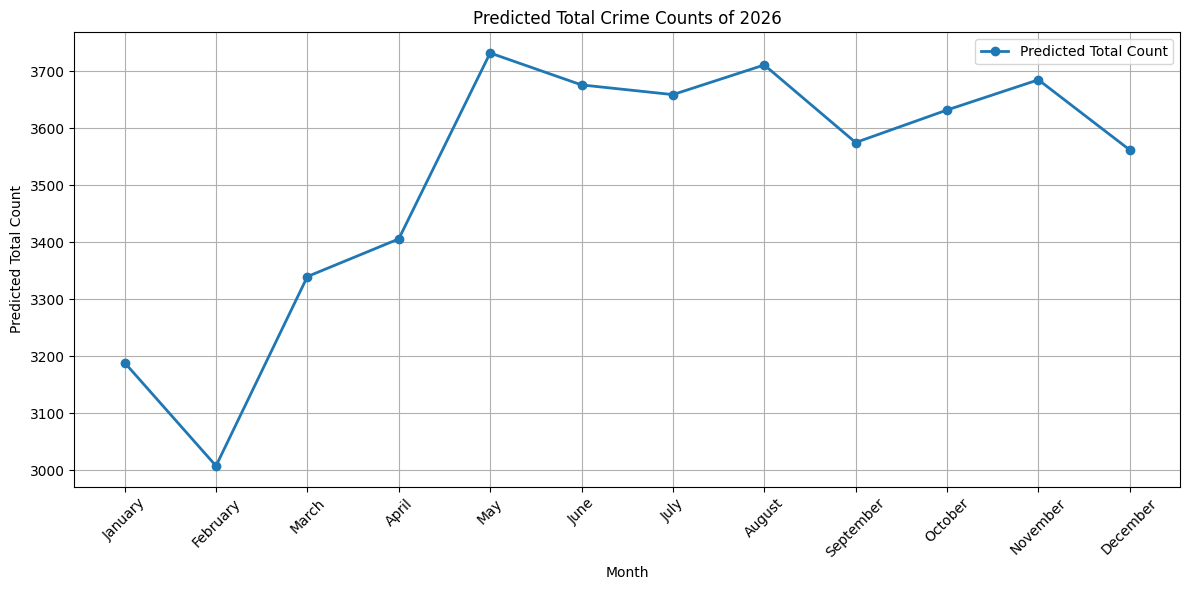

In [115]:
# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2026['OCC_MONTH'],
         crime_2026['Total_Counts'],
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts of 2026')
# Set x-ticks to the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [116]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2026. Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it. Sort the groupby by the Total_Counts column in descending order. Then filter the groupby to include just the first five rows

# Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2026.
crime_2026 = crime_2025_2027[crime_2025_2027['OCC_YEAR'] == 2026]

# Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it.
crime_groupby = crime_2026.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Counts'].sum().reset_index(name='Total_Counts')

# Sort the groupby by the Total_Counts column in descending order.
crime_groupby_sorted = crime_groupby.sort_values('Total_Counts', ascending=False)

# Then filter the groupby to include just the first five rows
top_5_neighborhoods_2026 = crime_groupby_sorted.head(5)

top_5_neighborhoods_2026

NEIGHBOURHOOD_158  OCC_YEAR  Total_Counts
139    West Humber-Clairville (1)      2026          1322
156  York University Heights (27)      2026           789
36      Downtown Yonge East (168)      2026           760
93                 Moss Park (73)      2026           747
152      Yonge-Bay Corridor (170)      2026           679

In [117]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2026 and NEIGHBOURHOOD_158 has the values in the top_5_neighborhoods_2026['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Counts column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Counts values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Counts value in top_5_neighborhoods_2026 Dataframe

# Filter crime_2025_2027 for 2026 and top 5 neighborhoods
crime_2026_top5 = crime_2025_2027[
    (crime_2025_2027['OCC_YEAR'] == 2026) &
    (crime_2025_2027['NEIGHBOURHOOD_158'].isin(top_5_neighborhoods_2026['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Counts
crime_2026_top5_grouped = crime_2026_top5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2026_top5_grouped,
    x='OCC_MONTH',
    y='Total_Counts',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Counts values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Counts values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = top_5_neighborhoods_2026.loc[top_5_neighborhoods_2026['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Counts'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Top 5 Neighborhoods for 2026')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

In [118]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2026. Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it. Sort the groupby by the Total_Counts column in ascending order. Then filter the groupby to include just the first five rows

# Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2026.
crime_2026 = crime_2025_2027[crime_2025_2027['OCC_YEAR'] == 2026]

# Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it.
crime_groupby = crime_2026.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Counts'].sum().reset_index(name='Total_Counts')

# Sort the groupby by the Total_Counts column in ascending order.
crime_groupby_sorted = crime_groupby.sort_values('Total_Counts', ascending=True)

# Then filter the groupby to include just the first five rows
low_5_neighborhoods_2026 = crime_groupby_sorted.head(5)

low_5_neighborhoods_2026

NEIGHBOURHOOD_158  OCC_YEAR  Total_Counts
150         Woodbine-Lumsden (60)      2026            93
78       Lambton Baby Point (114)      2026            95
64   Humber Heights-Westmount (8)      2026           113
107            Old East York (58)      2026           113
19           Broadview North (57)      2026           115

In [119]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2026 and NEIGHBOURHOOD_158 has the values in the low_5_neighborhoods_2026['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Counts column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Counts values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Counts value in low_5_neighborhoods_2026 Dataframe

# Filter crime_2025_2027 for 2026 and the neighborhoods in low_5_neighborhoods_2026
crime_2026_low5 = crime_2025_2027[
    (crime_2025_2027['OCC_YEAR'] == 2026) &
    (crime_2025_2027['NEIGHBOURHOOD_158'].isin(low_5_neighborhoods_2026['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Counts
crime_2026_low5_grouped = crime_2026_low5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2026_low5_grouped,
    x='OCC_MONTH',
    y='Total_Counts',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Counts values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Counts values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = low_5_neighborhoods_2026.loc[low_5_neighborhoods_2026['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Counts'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Low 5 Neighborhoods for 2026')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

<a id="5.2.6"></a>
#### Anticipated Crime Statistics for 2027

[back to the top](#0)

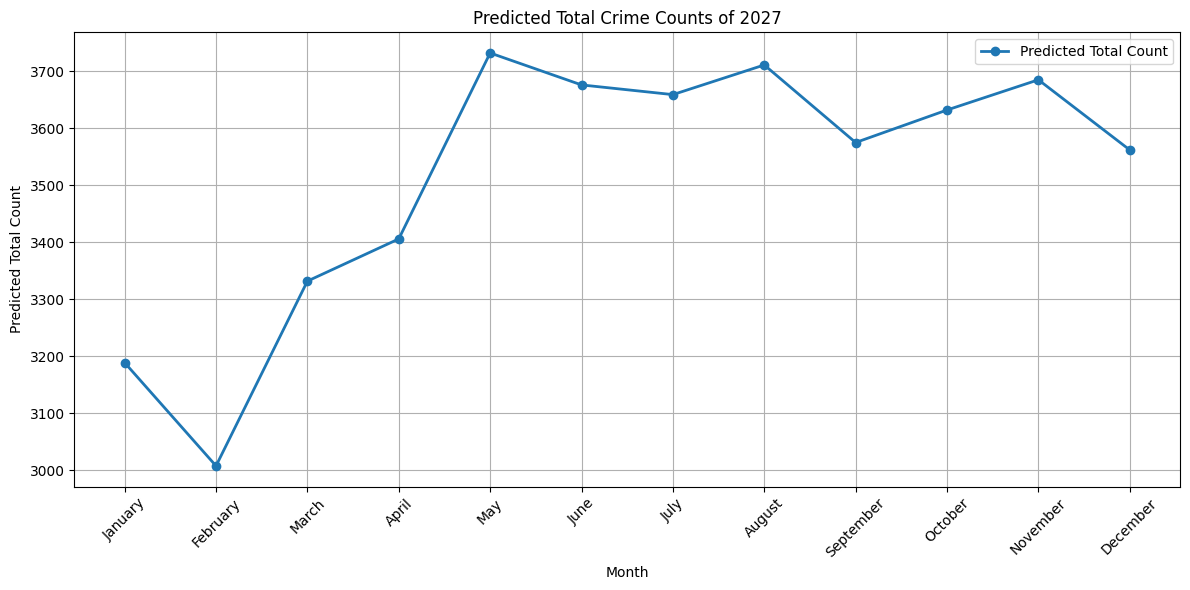

In [120]:
# Plotting the predicted results
plt.figure(figsize=(12, 6))
plt.plot(crime_2027['OCC_MONTH'],
         crime_2027['Total_Counts'],
         linewidth=2, marker='o', label='Predicted Total Count')

# Add labels, title, and legend
plt.xlabel('Month')
plt.ylabel('Predicted Total Count')
plt.title('Predicted Total Crime Counts of 2027')
# Set x-ticks to the month names
plt.xticks(ticks=range(1, 13), labels=month_names, rotation=45)
plt.grid(True)
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [121]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2027. Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it. Sort the groupby by the Total_Counts column in descending order. Then filter the groupby to include just the first five rows

# Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2027.
crime_2027 = crime_2025_2027[crime_2025_2027['OCC_YEAR'] == 2027]

# Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it.
crime_groupby = crime_2027.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Counts'].sum().reset_index(name='Total_Counts')

# Sort the groupby by the Total_Counts column in descending order.
crime_groupby_sorted = crime_groupby.sort_values('Total_Counts', ascending=False)

# Then filter the groupby to include just the first five rows
top_5_neighborhoods_2027 = crime_groupby_sorted.head(5)

top_5_neighborhoods_2027

NEIGHBOURHOOD_158  OCC_YEAR  Total_Counts
139    West Humber-Clairville (1)      2027          1322
156  York University Heights (27)      2027           789
36      Downtown Yonge East (168)      2027           760
93                 Moss Park (73)      2027           747
152      Yonge-Bay Corridor (170)      2027           679

In [126]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2027 and NEIGHBOURHOOD_158 has the values in the top_5_neighborhoods_2027['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Counts column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Counts values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Counts value in top_5_neighborhoods_2027 Dataframe

# Filter crime_2025_2027 for 2027 and top 5 neighborhoods
crime_2027_top5 = crime_2025_2027[
    (crime_2025_2027['OCC_YEAR'] == 2027) &
    (crime_2025_2027['NEIGHBOURHOOD_158'].isin(top_5_neighborhoods_2027['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Counts
crime_2027_top5_grouped = crime_2027_top5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2027_top5_grouped,
    x='OCC_MONTH',
    y='Total_Counts',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Counts values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Counts values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = top_5_neighborhoods_2027.loc[top_5_neighborhoods_2027['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Counts'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Top 5 Neighborhoods for 2027')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

In [123]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2027. Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it. Sort the groupby by the Total_Counts column in ascending order. Then filter the groupby to include just the first five rows

# Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2027.
crime_2027 = crime_2025_2027[crime_2025_2027['OCC_YEAR'] == 2027]

# Group crime_2025_2027 by NEIGHBOURHOOD_158 and OCC_YEAR columns and aggregate Total_Counts by summing it.
crime_groupby = crime_2027.groupby(['NEIGHBOURHOOD_158', 'OCC_YEAR'])['Total_Counts'].sum().reset_index(name='Total_Counts')

# Sort the groupby by the Total_Counts column in ascending order.
crime_groupby_sorted = crime_groupby.sort_values('Total_Counts', ascending=True)

# Then filter the groupby to include just the first five rows
low_5_neighborhoods_2027 = crime_groupby_sorted.head(5)

low_5_neighborhoods_2027

NEIGHBOURHOOD_158  OCC_YEAR  Total_Counts
150         Woodbine-Lumsden (60)      2027            85
78       Lambton Baby Point (114)      2027            95
64   Humber Heights-Westmount (8)      2027           113
107            Old East York (58)      2027           113
19           Broadview North (57)      2027           115

In [125]:
# prompt: Filter crime_2025_2027 to only include rows in which OCC_YEAR column has the value 2027 and NEIGHBOURHOOD_158 has the values in the low_5_neighborhoods_2027['NEIGHBOURHOOD_158'] column. Then plot a chart of the Total_Counts column for each neighbourhood and for each month in OCC_MONTH. Annotate the data points in the plot the Total_Counts values. Have the legend include not just the NEIGHBOURHOOD_158 value but also the associated Total_Counts value in low_5_neighborhoods_2027 Dataframe

# Filter crime_2025_2027 for 2027 and the neighborhoods in low_5_neighborhoods_2027
crime_2027_low5 = crime_2025_2027[
    (crime_2025_2027['OCC_YEAR'] == 2027) &
    (crime_2025_2027['NEIGHBOURHOOD_158'].isin(low_5_neighborhoods_2027['NEIGHBOURHOOD_158']))
]

# Group by neighborhood and month, summing the Total_Counts
crime_2027_low5_grouped = crime_2027_low5.groupby(['NEIGHBOURHOOD_158', 'OCC_MONTH'])['Total_Counts'].sum().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=crime_2027_low5_grouped,
    x='OCC_MONTH',
    y='Total_Counts',
    hue='NEIGHBOURHOOD_158',
    marker='o'
)

# Annotate data points with Total_Counts values
for line in ax.lines:
  for x, y in zip(line.get_xdata(), line.get_ydata()):
    ax.annotate(f"{y:.0f}", (x, y), textcoords="offset points", xytext=(0, 5), ha='center')

# Customize legend to include Total_Counts values
handles, labels = ax.get_legend_handles_labels()
new_labels = []
for label in labels:
  neighborhood = label
  total_count = low_5_neighborhoods_2027.loc[low_5_neighborhoods_2027['NEIGHBOURHOOD_158'] == neighborhood, 'Total_Counts'].iloc[0]
  new_labels.append(f"{neighborhood} (Yearly Total Count: {total_count})")
ax.legend(handles=handles, labels=new_labels, title='Neighborhood')

# Set the title and labels for the plot
plt.title('Total Crime Counts in Low 5 Neighborhoods for 2027')
plt.xlabel('Month')
plt.ylabel('Total Crime Count')
plt.xticks(ticks=range(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.tight_layout()
plt.show()
# Display the neighbourhood map m
m

Output hidden; open in https://colab.research.google.com to view.

<a id="6"></a>
## **Summary and Conclusion**